# Configuration de MLFlow avec tracking local

In [1]:
# pip install mlflow
import mlflow

In [2]:
# Asignation du serveur de tracking MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Cr√©ation de l'exp√©rimentation "approche classique"
mlflow.set_experiment("modele_avanc√©")

<Experiment: artifact_location='mlflow-artifacts:/566106427225564143', creation_time=1729147540629, experiment_id='566106427225564143', last_update_time=1729147540629, lifecycle_stage='active', name='modele_avanc√©', tags={}>

### Donn√©es

In [3]:
import pandas as pd
# dataframes avec toutes les colonnes
train_df = pd.read_csv("./data/train_df.csv")
test_df = pd.read_csv("./data/test_df.csv")
val_df = pd.read_csv("./data/val_df.csv")
# dataframe complet avec colonnes target et text
tweets_df = pd.read_csv("./data/data_autoML.csv")

In [4]:
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

# Word2Vec

In [4]:
# # utilisation dans Google collab
# print('Mounting your Google Drive...')
# from google.colab import drive
# drive.mount('/content/drive')
# print('Opening the file...')
# %cd /content/drive/My Drive/P7
# !ls

In [5]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [6]:
import multiprocessing
# Param√®tres du mod√®le Word2Vec
w2v_size = 300        # Taille des vecteurs
w2v_window = 5        # Taille de la fen√™tre contextuelle
w2v_min_count = 1     # Nombre minimum d'occurrences d'un mot pour √™tre pris en compte
w2v_epochs = 50      # Nombre d'it√©rations (√©poques)
workers = multiprocessing.cpu_count()  # Utilisation de tous les c≈ìurs disponibles

### Pr√©paration des sentences

In [7]:
# Pr√©paration des sentences √† partir de la colonne 'preprocessed_text'
# Tokenisation de chaque phrase en s√©parant les mots sur les espaces
train_sentences = [sentence.split() for sentence in train_df['preprocessed_text'].astype(str)]
val_sentences = [sentence.split() for sentence in val_df['preprocessed_text'].astype(str)]
test_sentences = [sentence.split() for sentence in test_df['preprocessed_text'].astype(str)]

### Mod√®le Word2Vec

In [8]:
from gensim.models import Word2Vec
# Instanciation du mod√®le Word2Vec
w2v_model = Word2Vec(
    sentences=train_sentences,   # Les phrases tokenis√©es d'entra√Ænement
    vector_size=w2v_size,        # Taille des vecteurs
    window=w2v_window,           # Taille de la fen√™tre contextuelle
    min_count=w2v_min_count,     # Seuil d'apparition minimum d'un mot
    workers=workers,             # Nombre de threads (CPU cores) √† utiliser
    sg=1                         # Utilisation de Skip-gram (si sg=0, on utilise CBOW)
)

In [9]:
# Entra√Ænement du mod√®le
w2v_model.train(train_sentences, total_examples=len(train_sentences), epochs=w2v_epochs)

(1414627, 1728450)

In [10]:
# Sauvegarde du mod√®le apr√®s entra√Ænement
w2v_model.save("./models/word2vec_model.model")

### Matrice d'embeddings

In [11]:
# Extraction de la matrice d'embedding
embedding_matrix_w2v = []
for word in w2v_model.wv.index_to_key:
    embedding_matrix_w2v.append(w2v_model.wv[word])

# Conversion en numpy array
import numpy as np
embedding_matrix_w2v = np.array(embedding_matrix_w2v)

# Dimensions de la matrice d'embedding : vocab_size x w2v_size
print("Matrice d'embedding de taille :", embedding_matrix_w2v.shape)

Matrice d'embedding de taille : (6109, 300)


### Pr√©paration des donn√©es pour l'ex√©cution du mod√®le

In [12]:
# Param√®tres
maxlen = 40  # Longueur maximale des s√©quences de mots

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Cr√©ation d'un dictionnaire mot->index √† partir du vocabulaire de Word2Vec
word_index = {word: i for i, word in enumerate(w2v_model.wv.index_to_key)}

# Fonction pour convertir les phrases en s√©quences d'index
def sentences_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        seq = [word_index.get(word, 0) for word in sentence]  # Remplacer les mots inconnus par 0
        sequences.append(seq)
    return sequences

# Conversion des phrases d'entra√Ænement et de test en s√©quences d'index
train_sequences = sentences_to_sequences(train_sentences, word_index)
val_sequences = sentences_to_sequences(val_sentences, word_index)
test_sequences = sentences_to_sequences(test_sentences, word_index)

# Padding des s√©quences pour qu'elles aient toutes la m√™me longueur (maxlen)
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

# Exemple d'affichage des s√©quences apr√®s padding
print(train_padded[:5])


[[ 338  121   19   25    2  180    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  127 3641    0  209  434   39    2    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  927    0  106    0  996    2 3633    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   3 3631   17 1018 1096    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  190  536  235  165   88   37  600    6 1624   35    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

### Mod√®les tests d'embedding Keras

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

vocab_size_w2v = len(w2v_model.wv.index_to_key)  # Taille du vocabulaire
print("Taille du vocabulaire dans W2Vec :", vocab_size_w2v)

Taille du vocabulaire dans W2Vec : 6109


In [14]:
# G√©n√©ration de donn√©es d'entra√Ænement fictives (100 √©chantillons, chaque s√©quence de longueur maxlen pour la construction des mod√®les
fictive_data = np.random.randint(0, vocab_size_w2v, size=(100, maxlen))
fictive_labels = np.random.randint(0, 2, size=(100,))

In [15]:
import mlflow
import mlflow.keras
from keras.callbacks import Callback, CSVLogger, ModelCheckpoint  # Importer Callback ici
import os

# Cr√©er un r√©pertoire pour sauvegarder les logs d'entra√Ænement s'il n'existe pas
import os
if not os.path.exists('./history'):
    os.makedirs('./history')

# Callback pour sauvegarder les m√©triques dans un fichier CSV
csv_logger = CSVLogger('./history/training_log.csv', append=True)

In [20]:
import os
import mlflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, Callback
from mlflow.models.signature import infer_signature
import tensorflow as tf

def train_model_with_mlflow(
    model, 
    train_data, 
    train_labels, 
    validation_data, 
    validation_labels, 
    epochs, 
    batch_size, 
    learning_rate, 
    run_name="training_model",
    callbacks=None  # Permet d'ajouter des callbacks personnalis√©s
):
    # Cr√©er le r√©pertoire pour sauvegarder l'historique si inexistant
    os.makedirs('./history', exist_ok=True)

    # Initialiser un run MLflow
    with mlflow.start_run(run_name=run_name) as run:
        
        # Initialiser et compiler le mod√®le avec le learning rate donn√©
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        
        # Logguer le learning rate initial
        mlflow.log_param("initial_learning_rate", learning_rate)
        
        # Callback personnalis√© pour logger les m√©triques dans MLflow apr√®s chaque √©poque
        class LogMetricsCallback(Callback):
            def on_epoch_end(self, epoch, logs=None):
                mlflow.log_metric("2_train_loss", logs["loss"], step=epoch)
                mlflow.log_metric("3_val_loss", logs["val_loss"], step=epoch)
                mlflow.log_metric("4_train_accuracy", logs["accuracy"], step=epoch)
                mlflow.log_metric("5_val_accuracy", logs["val_accuracy"], step=epoch)
                current_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
                mlflow.log_metric("learning_rate", current_lr, step=epoch)

        # Callback pour sauvegarder les m√©triques dans un fichier CSV
        csv_logger = CSVLogger('./history/training_log.csv', append=False)

        # Callback pour sauvegarder le meilleur mod√®le
        checkpoint = ModelCheckpoint(
            './history/best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )

        # Scheduler pour ajuster dynamiquement le learning rate
        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )

        # Combiner les callbacks de la fonction avec ceux sp√©cifi√©s par l'utilisateur
        all_callbacks = [LogMetricsCallback(), csv_logger, checkpoint, lr_scheduler]
        if callbacks:
            all_callbacks.extend(callbacks)

        # Entra√Ænement du mod√®le avec les callbacks
        history = model.fit(
            train_data,
            train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(validation_data, validation_labels),
            verbose=1,
            callbacks=all_callbacks
        )

        # Logguer l'historique dans MLflow
        mlflow.log_artifact('./history/training_log.csv')

        # Logguer le meilleur mod√®le dans MLflow
        mlflow.keras.log_model(model, "best_model")

        # Enregistrer des hyperparam√®tres pour r√©f√©rence
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)

        # Cr√©er la signature du mod√®le
        signature = infer_signature(train_data, model.predict(train_data))
        # Log du mod√®le avec signature
        mlflow.keras.log_model(model, "model_with_signature", signature=signature)

    return history


#### Mod√®le 1 LSTM simple
- Entr√©e: dimensionn√©e par la taille de l'embedding de W2v et dont les poids sont ceux de la matrice d'embedding
- Couche LSTM
- Couche dense pour une classification binaire

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Instanciation du mod√®le s√©quentiel 1
model_W2v_1 = Sequential()

# Ajout de la couche d'embedding avec la matrice pr√©-entra√Æn√©e
model_W2v_1.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,            # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Utilisation de la matrice d'embedding pr√©-entra√Æn√©e
    trainable=False                 # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM pour capturer les relations s√©quentielles
model_W2v_1.add(LSTM(128))

# # Ajout de la premi√®re couche Dense avec 64 unit√©s et activation ReLU
# model_W2v_1.add(Dense(64, activation='relu'))

# # Ajout de la deuxi√®me couche Dense avec 32 unit√©s et activation ReLU
# model_W2v_1.add(Dense(32, activation='relu'))

# Ajout d'une couche de sortie (par exemple, pour de la classification binaire)
model_W2v_1.add(Dense(1, activation='sigmoid'))


In [30]:
# Param√®tres d'entrainement communs
n_epochs = 50
batch_size = 16
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial si on est √† 10-3 l'apprentissage ne commence pas  !!!!

In [32]:
# Appel de la fonction d'entra√Ænement avec MLflow
history_1 = train_model_with_mlflow(
    model=model_W2v_1,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_1_LSTM128"
)


Epoch 1/50
210/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.7159 - loss: 0.5639
Epoch 1: val_loss improved from inf to 0.61725, saving model to ./history/best_model.keras
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 12ms/step - accuracy: 0.7159 - loss: 0.5637 - val_accuracy: 0.6745 - val_loss: 0.6172 - learning_rate: 1.0000e-04
Epoch 2/50
211/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.7333 - loss: 0.5471
Epoch 2: val_loss improved from 0.61725 to 0.57692, saving model to ./history/best_model.keras
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 11ms/step - accuracy: 0.7332 - loss: 0.5472 - val_accuracy: 0.6841 - val_loss: 0.5769 - learning_rate: 1.0000e-04
Epoch 3/50
211/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.7298 - loss: 0.5299
Epoch 3: val_loss improved from 0.57692 to 0.57324, saving model

2024/10/28 18:31:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 18:31:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 18:31:20 INFO mlflow.tracking._tracking_service.client: üèÉ View run training_model_W2v_1_LSTM128 at: http://localhost:5000/#/experiments/566106427225564143/runs/e178da81160c4b85b571c1cc9e19c467.
2024/10/28 18:31:20 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le mod√®le est tr√®s sensible au learning rate (au-del√† de la valeur initiale choisie il n'apprend pas).<br>
L'ajout de couches denses pour limiter rendre moins abrupt le passage des donn√©es LSTM vers un classifieur donne √©galment lieu √† une disparition du gradient.
Il y a √©galement un probl√®me de sur-ajustement. Une fois la valeur de l'erreur minimis√©e sur train, val_loss augmente. Les causes peuvent √™tre multiples: mod√®le trop simple, LSTM non optimis√©. Nous allons explorer diff√©rentes am√©liorations.

#### Mod√®le 2 LSTM double, ajout de couches dense, dropout
- Entr√©e: dimensionn√©e par la taille de l'embedding de W2v et dont les poids sont ceux de la matrice d'embedding
- Deux couches LSTM 128 et 64 pour capturer les relations distantes et de proximit√©
- Ajout de couches denses interm√©diaires 
- Dropout entre les couches pour complexifier l'apprentissage

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.initializers import HeNormal

# Instanciation du mod√®le s√©quentiel 2
model_W2v_2 = Sequential()

# Ajout de la couche d'embedding avec la matrice pr√©-entra√Æn√©e
model_W2v_2.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,            # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Utilisation de la matrice d'embedding pr√©-entra√Æn√©e
    trainable=False                 # Geler les poids de l'embedding
))

# Premi√®re couche LSTM avec return_sequences=True pour passer la s√©quence compl√®te
model_W2v_2.add(LSTM(128, return_sequences=True))
model_W2v_2.add(Dropout(0.3))  # Ajouter Dropout pour la r√©gularisation
# model_W2v_2.add(BatchNormalization())

# Seconde couche LSTM avec 64 unit√©s (pas de dropout: le mod√®le n'arrive plus √† r√©soudre, loss augmente
model_W2v_2.add(LSTM(64))
# model_W2v_2.add(BatchNormalization()) 

# Diminution progressive des dimensions
model_W2v_2.add(Dense(32, activation='relu'))
# model_W2v_2.add(BatchNormalization())

# model_W2v_2.add(Dense(32, activation='relu'))
# model_W2v_2.add(BatchNormalization())

# Couche de sortie pour la classification binaire
model_W2v_2.add(Dense(1, activation='sigmoid'))


In [77]:
# Param√®tres d'entrainement communs
n_epochs = 100
batch_size = 16
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial

In [78]:
# Appel de la fonction d'entra√Ænement avec MLflow
history_2 = train_model_with_mlflow(
    model=model_W2v_2,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_2_LSTM128+64_Dense_Dropout"
)


Epoch 1/100
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - accuracy: 0.4933 - loss: 0.6963
Epoch 1: val_loss improved from inf to 0.69417, saving model to ./history/best_model.keras
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.4933 - loss: 0.6963 - val_accuracy: 0.4986 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 2/100
212/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - accuracy: 0.4824 - loss: 0.6952
Epoch 2: val_loss improved from 0.69417 to 0.69380, saving model to ./history/best_model.keras
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 17ms/step - accuracy: 0.4825 - loss: 0.6952 - val_accuracy: 0.5014 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 3/100
212/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - accuracy: 0.5024 - loss: 0.6940
Epoch 3: val_loss did not improve from 0.69380
213/213 ‚îÅ

2024/10/28 20:53:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 20:53:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 20:53:51 INFO mlflow.tracking._tracking_service.client: üèÉ View run training_model_W2v_2_LSTM128+64_Dense_Dropout at: http://localhost:5000/#/experiments/566106427225564143/runs/16ac0412c2444464b6b235ac2e1e03b5.
2024/10/28 20:53:51 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le mod√®le converge de fa√ßon moins cahotique et supporte l'ajout d'une couche dense interm√©diaire avec Relu  qui corrige le surajustement, la batch normalisation permet normalement de r√©duire la disparition du gradient mais son effet n'a pas √©t√© d√©tectable, tout au moins elle permet d'introduire une seconde couche dense sans que le gradient disparaisse.

### Mod√®le 3 LSTM r√©gularisation L2 et dropout
Une autre fa√ßon de r√©duire le sur-apprentissage (l2 p√©nalise les poids √©lev√©s avec un terme de p√©nalit√© proportionnel √† la somme des carr√©s des poids au calcul de la fonction de perte)

In [114]:
# Mod√®le 3 avec dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# R√©gularisation l2 pour √©viter le sur-apprentissage

model_W2v_3 = Sequential()
model_W2v_3.add(Embedding(input_dim=vocab_size_w2v, output_dim=w2v_size, weights=[embedding_matrix_w2v],
                    trainable=False))
model_W2v_3.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))  # Ajout de la r√©gularisation L2
model_W2v_3.add(Dropout(0.3))
model_W2v_3.add(LSTM(64, kernel_regularizer=l2(0.001)))
model_W2v_3.add(Dropout(0.3))  # Dropout de 30% des neurones
model_W2v_3.add(BatchNormalization())
# model_W2v_3.add(Dense(32, activation='relu'))
model_W2v_3.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))  # Ajout L2 dans la couche Dense


In [115]:
# Param√®tres d'entrainement communs
n_epochs = 50
batch_size = 16
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial

In [116]:
# Appel de la fonction d'entra√Ænement avec MLflow
history_3 = train_model_with_mlflow(
    model=model_W2v_3,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_3_LSTM128+64_L2"
)


Epoch 1/50
212/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - accuracy: 0.5072 - loss: 1.3954
Epoch 1: val_loss improved from inf to 1.19374, saving model to ./history/best_model.keras
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 20ms/step - accuracy: 0.5072 - loss: 1.3952 - val_accuracy: 0.5014 - val_loss: 1.1937 - learning_rate: 1.0000e-04
Epoch 2/50
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - accuracy: 0.4899 - loss: 1.3552
Epoch 2: val_loss did not improve from 1.19374
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 18ms/step - accuracy: 0.4899 - loss: 1.3551 - val_accuracy: 0.4986 - val_loss: 1.2029 - learning_rate: 1.0000e-04
Epoch 3/50
210/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - accuracy: 0.4973 - loss: 1.2880
Epoch 3: val_loss did not improve from 1.19374
213/213 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

2024/10/28 21:51:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 21:51:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 21:51:46 INFO mlflow.tracking._tracking_service.client: üèÉ View run training_model_W2v_3_LSTM128+64_L2 at: http://localhost:5000/#/experiments/566106427225564143/runs/f6e5f92ac3614a269be23bcd2692209c.
2024/10/28 21:51:46 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le mod√®le d√®s qu'il est assez r√©gul√© tend vers des solutions triviales (accuracy 0.5)

### Mod√®le 4 LSTM bidirectionnel

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout


# Instanciation du mod√®le s√©quentiel 4
model_W2v_4 = Sequential()

# Ajout de la couche d'embedding avec la matrice pr√©-entra√Æn√©e
model_W2v_4.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,            # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Utilisation de la matrice d'embedding pr√©-entra√Æn√©e
    trainable=False                 # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM bidirectionnelle avec r√©gularisation L2
model_W2v_4.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.01))))

# Ajout d'une couche Dropout pour √©viter le sur-ajustement
model_W2v_4.add(Dropout(0.5)) 

# model_W2v_4.add(Dense(64, activation='relu'))
# model_W2v_4.add(Dropout(0.5))

# Ajout d'une couche de sortie pour la classification binaire
model_W2v_4.add(Dense(1, activation='sigmoid'))


# Compilation du mod√®le
model_W2v_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [139]:
# Param√®tres d'entrainement communs
n_epochs = 50
batch_size = 32
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial

In [140]:
# Appel de la fonction d'entra√Ænement avec MLflow
history_4 = train_model_with_mlflow(
    model=model_W2v_4,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_4_BLSTM128"
)


Epoch 1/50
105/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - accuracy: 0.5227 - loss: 7.6971
Epoch 1: val_loss improved from inf to 6.09038, saving model to ./history/best_model.keras
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 20ms/step - accuracy: 0.5228 - loss: 7.6819 - val_accuracy: 0.6099 - val_loss: 6.0904 - learning_rate: 1.0000e-04
Epoch 2/50
105/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - accuracy: 0.5797 - loss: 5.6754
Epoch 2: val_loss improved from 6.09038 to 4.51427, saving model to ./history/best_model.keras
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 17ms/step - accuracy: 0.5801 - loss: 5.6643 - val_accuracy: 0.6277 - val_loss: 4.5143 - learning_rate: 1.0000e-04
Epoch 3/50
105/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - accuracy: 0.6198 - loss: 4.2150
Epoch 3: val_loss improved from 4.51427 to 3.38018, saving mo

2024/10/28 22:34:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 22:34:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 22:34:31 INFO mlflow.tracking._tracking_service.client: üèÉ View run training_model_W2v_4_BLSTM128 at: http://localhost:5000/#/experiments/566106427225564143/runs/1ec8797641954924bd35c940f39a0897.
2024/10/28 22:34:31 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


### Mod√®le 5 GRU

In [161]:
# Code du mod√®le avec GRU, Dropout et r√©gularisation L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Importer Adam pour ajuster le learning rate

# Param√®tres de r√©gularisation et Dropout
dropout_rate = 0      # Pourcentage de neurones ignor√©s
l2_lambda = 0        # Facteur de r√©gularisation L2
learning_rate = 0.0001  # Taux d'apprentissage sp√©cifique

In [162]:
# Instanciation du mod√®le s√©quentiel
model_W2v_5 = Sequential()

# 1. Couche d'embedding avec la matrice Word2Vec pr√©-entra√Æn√©e
model_W2v_5.add(Embedding(
    input_dim=vocab_size_w2v,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix_w2v], # Matrice d'embedding pr√©-entra√Æn√©e
    trainable=False             # Geler les poids de l'embedding
))

# 2. Couche GRU avec Dropout et r√©gularisation L2
model_W2v_5.add(GRU(
    units=128,                    # Nombre d'unit√©s GRU
    kernel_regularizer=l2(l2_lambda),  # R√©gularisation L2 sur les poids
    recurrent_regularizer=l2(l2_lambda),  # R√©gularisation L2 sur les poids r√©currents
    dropout=dropout_rate,         # Dropout sur les connexions entrantes
    recurrent_dropout=dropout_rate  # Dropout sur les connexions r√©currentes
))

# 3. Couche de sortie Dense avec r√©gularisation L2
model_W2v_5.add(Dense(
    units=1,                      # Pour une t√¢che de classification binaire
    activation='sigmoid',          # Sigmoid pour la probabilit√© binaire
    kernel_regularizer=l2(l2_lambda)  # R√©gularisation L2 sur la couche de sortie
))

In [163]:
# Appel de la fonction d'entra√Ænement avec MLflow
history_5 = train_model_with_mlflow(
    model=model_W2v_5,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_W2v_5_GRU_L2"
)


Epoch 1/50
106/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - accuracy: 0.4897 - loss: 0.6991
Epoch 1: val_loss improved from inf to 0.69561, saving model to ./history/best_model.keras
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 16ms/step - accuracy: 0.4897 - loss: 0.6991 - val_accuracy: 0.5014 - val_loss: 0.6956 - learning_rate: 1.0000e-04
Epoch 2/50
106/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - accuracy: 0.4975 - loss: 0.6962
Epoch 2: val_loss improved from 0.69561 to 0.69314, saving model to ./history/best_model.keras
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 14ms/step - accuracy: 0.4973 - loss: 0.6962 - val_accuracy: 0.5014 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/50
105/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - accuracy: 0.4992 - loss: 0.6952
Epoch 3: val_loss did not improve from 0.69314
107/107 ‚îÅ‚îÅ

2024/10/28 22:57:14 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/28 22:57:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/28 22:57:19 INFO mlflow.tracking._tracking_service.client: üèÉ View run training_model_W2v_5_GRU_L2 at: http://localhost:5000/#/experiments/566106427225564143/runs/9e0040f3b64f408a8268cd1d5a8fbda3.
2024/10/28 22:57:19 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


### Visualisation de l'entrainement des mod√®les

In [35]:
# pip install plot-keras-history
# Source: @software{Cappelletti_Plot_Keras_History_2022,
#     author = {Cappelletti, Luca},
#     doi = {10.5072/zenodo.1054923},
#     month = {4},
#     title = {{Plot Keras History}},
#     version = {1.1.36},
#     year = {2022}
# }

C:\Users\cecil\AppData\Local\Temp\ipykernel_3816\2269255762.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Ajuster les espacements


<Figure size 1000x500 with 0 Axes>

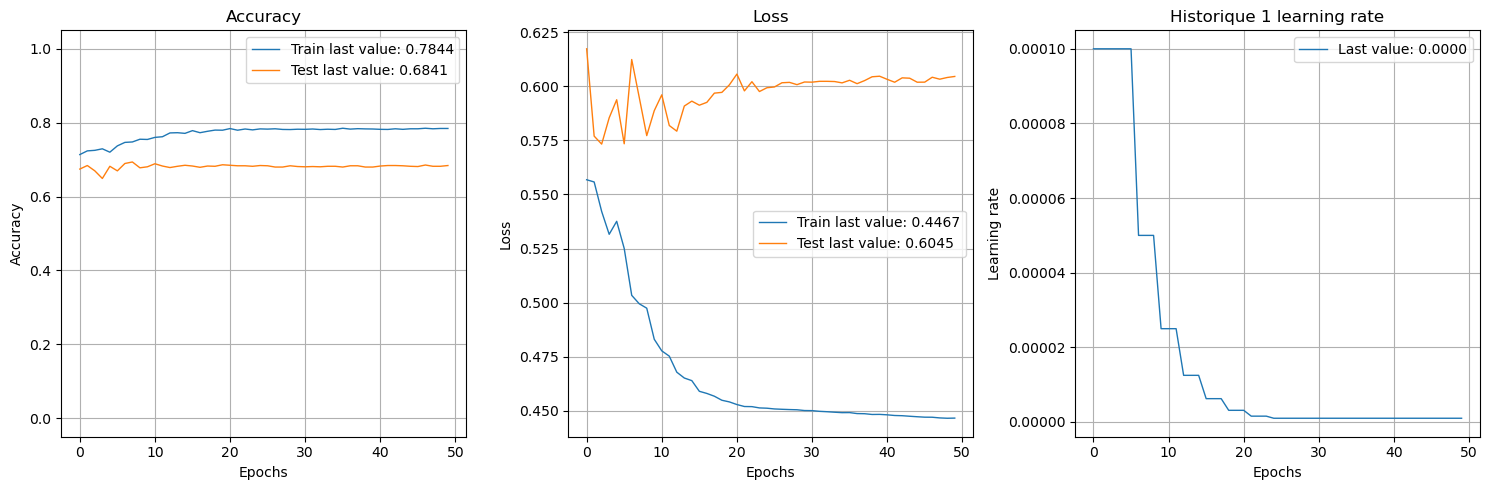

<Figure size 1000x500 with 0 Axes>

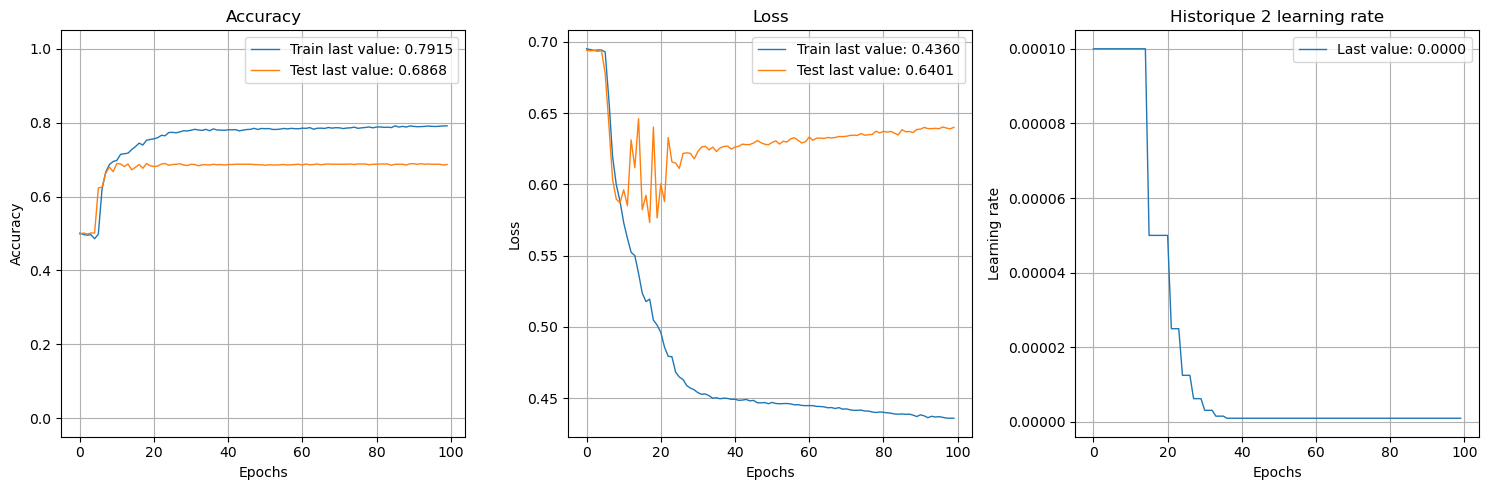

<Figure size 1000x500 with 0 Axes>

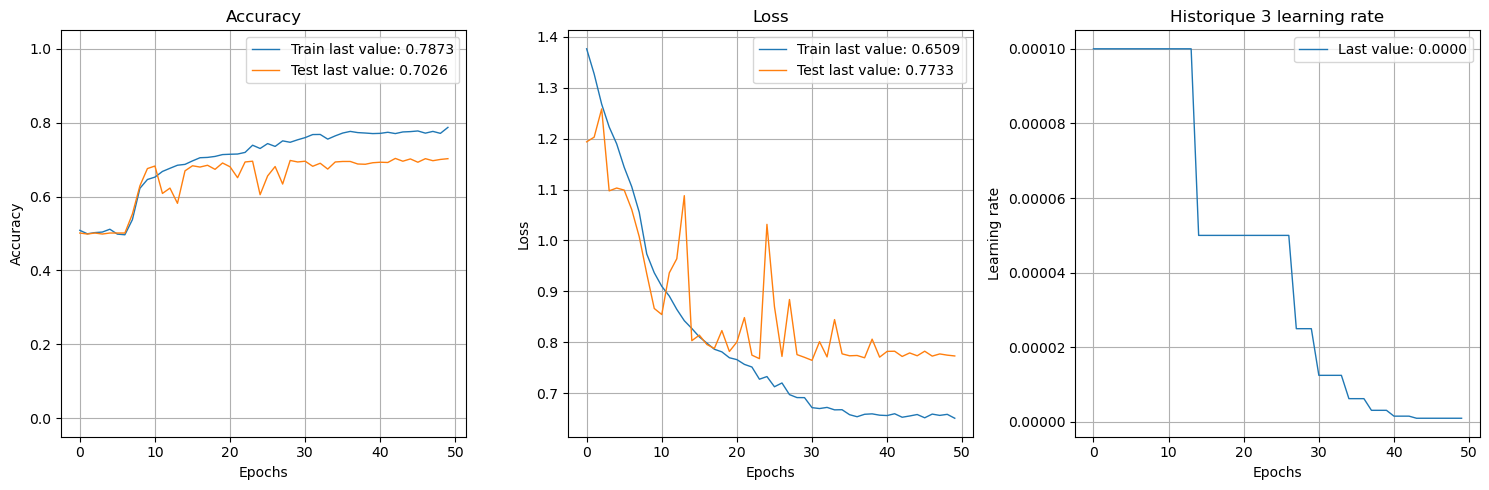

<Figure size 1000x500 with 0 Axes>

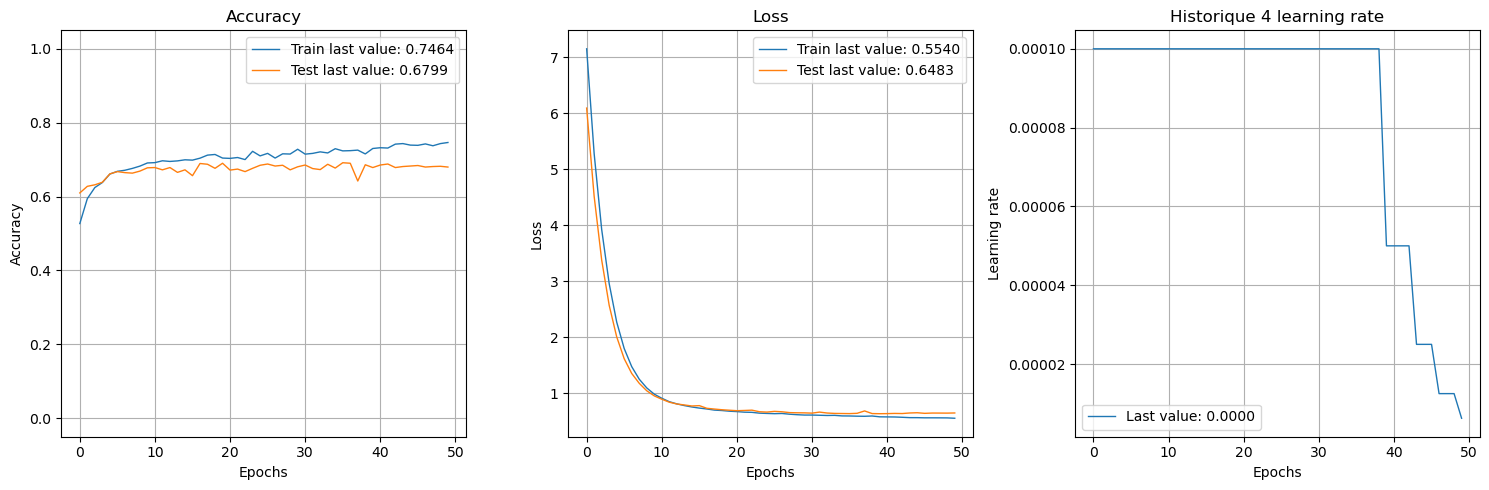

<Figure size 1000x500 with 0 Axes>

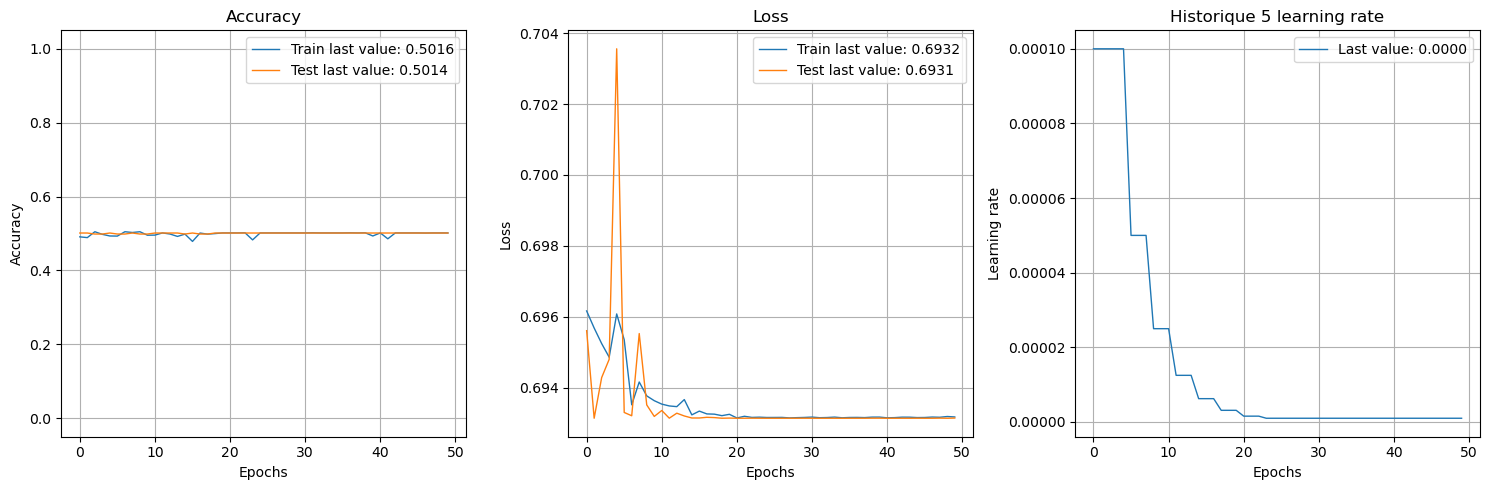

In [164]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

# Supposons que tu as plusieurs historiques
histories = [history_1, history_2, history_3, history_4, history_5]  

# Afficher chaque historique dans un nouveau graphe
for i, history in enumerate(histories):
    plt.figure(figsize=(10, 5))  # Cr√©er une nouvelle figure pour chaque historique
    plot_history(history.history)  # Afficher l'historique
    plt.title(f'Historique {i+1} learning rate')  # Ajouter un titre sp√©cifique
    plt.tight_layout()  # Ajuster les espacements
    plt.show()

## Optimisation automatique du mod√®le d'embedding

Utilisation de <u><b>Keras tuner</b></u> pour optimiser le mod√®le en faisant varier:<br>
- le nombre d'unit√©s LSTM
- le taux de dropout
- la r√©gularisation L2
- le taux d'apprentissage <br>
Le mod√®le utilise une couche LSTM bi-directionnelle √† laquelle on a ajout√© des couches denses (r√©gul√©es et avec dropout) qui r√©duisent progressivement les dimensions vers la couche de sortie.

In [29]:
def build_model(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec la matrice Word2Vec pr√©-entra√Æn√©e
    model.add(Embedding(
        input_dim=embedding_matrix_w2v.shape[0],     
        output_dim=embedding_matrix_w2v.shape[1],         
        weights=[embedding_matrix_w2v],          
        trainable=False              
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparam√®tres tunables
    lstm_units = hp.Int('units', min_value=128, max_value=512, step=64)
    model.add(Bidirectional(LSTM(
        units=lstm_units,
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log')),  # Intervalle ajust√©
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1),  # Dropout ajust√©
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1),
        return_sequences=False
    )))

    # 3. Premi√®re couche Dense avec r√©gularisation L2 et activation ReLU
    dense_units_1 = hp.Int('dense_units_1', min_value=lstm_units//4, max_value=lstm_units//2, step=32)
    model.add(Dense(
        units=dense_units_1,
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log'))
    ))
    model.add(Dropout(hp.Float('dense_dropout_1', min_value=0.1, max_value=0.3, step=0.1)))

    # 4. Deuxi√®me couche Dense avec r√©gularisation L2 et activation ReLU
    dense_units_2 = hp.Int('dense_units_2', min_value=dense_units_1//2, max_value=dense_units_1, step=16)
    model.add(Dense(
        units=dense_units_2,
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log'))
    ))
    model.add(Dropout(hp.Float('dense_dropout_2', min_value=0.1, max_value=0.3, step=0.1)))

    # 5. Couche de sortie Dense avec r√©gularisation L2
    model.add(Dense(
        units=1,                      
        activation='sigmoid',          
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-6, max_value=1e-3, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))

    # Compilation du mod√®le
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [30]:
# pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [31]:
import os
import shutil
# Supprimer le r√©pertoire s'il existe d√©j√† (pour refaire une mise au point de param√®tres √† chaque run)
if os.path.exists('my_dir'):
    shutil.rmtree('my_dir')

# Instanciation du tuner apr√®s suppression
tuner_W2v = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='my_dir',  # R√©pertoire standard mais il sera recr√©√©
    project_name='lstm_bidirectional_tuning_W2v'
)

In [ ]:
# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparam√®tres
tuner_W2v.search(train_padded, y_train, epochs=50, validation_data=(val_padded, y_val), callbacks=[stop_early])

Trial 205 Complete [00h 06m 13s]
val_loss: 0.5639243125915527

Best val_loss So Far: 0.5617563724517822
Total elapsed time: 14h 46m 00s

Search: Running Trial #206

Value             |Best Value So Far |Hyperparameter
512               |384               |units
1.5509e-06        |1.1095e-06        |l2_lambda
0.2               |0.3               |dropout_rate
64                |64                |dense_units_1
0.1               |0.1               |dense_dropout_1
32                |16                |dense_units_2
0.2               |0.1               |dense_dropout_2
0.0003026         |0.0050592         |learning_rate
34                |12                |tuner/epochs
12                |4                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
2                 |1                 |tuner/round
0190              |0168              |tuner/trial_id

Epoch 13/34
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 127s 1s/step - accuracy: 0.72

In [33]:
# Param√®tres d'entrainement pour le r√©-entrainement
n_epochs = 100
batch_size = 32
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial

In [34]:
# R√©cup√©ration des meilleurs hyperparam√®tres
best_hps_W2v = tuner_W2v.get_best_hyperparameters(num_trials=1)[0]

# Entra√Æner le meilleur mod√®le avec ces hyperparam√®tres (utilisation de la fonction des mod√®les tests)
best_model_W2v = tuner_W2v.hypermodel.build(best_hps_W2v)

# Appel de la fonction d'entra√Ænement avec MLflow
history_W2v_tuned = train_model_with_mlflow(
    model=best_model_W2v,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="best_model_W2v"
)

Epoch 1/100
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5239 - loss: 0.6915
Epoch 1: val_loss improved from inf to 0.65960, saving model to ./history/best_model.keras
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 159s 1s/step - accuracy: 0.5242 - loss: 0.6915 - val_accuracy: 0.6129 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 2/100
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.6113 - loss: 0.6592
Epoch 2: val_loss improved from 0.65960 to 0.62416, saving model to ./history/best_model.keras
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 150s 1s/step - accuracy: 0.6114 - loss: 0.6592 - val_accuracy: 0.6561 - val_loss: 0.6242 - learning_rate: 1.0000e-04
Epoch 3/100
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.6390 - loss: 0.6308
Epoch 3: val_loss improved from 0.62416 to 0.61621, saving model

2024/11/13 08:15:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/13 08:15:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 73s 663ms/step


2024/11/13 08:16:54 INFO mlflow.tracking._tracking_service.client: üèÉ View run best_model_W2v at: http://localhost:5000/#/experiments/566106427225564143/runs/6ab2afb9348e43b097de4c7ee034a1fe.
2024/11/13 08:16:54 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

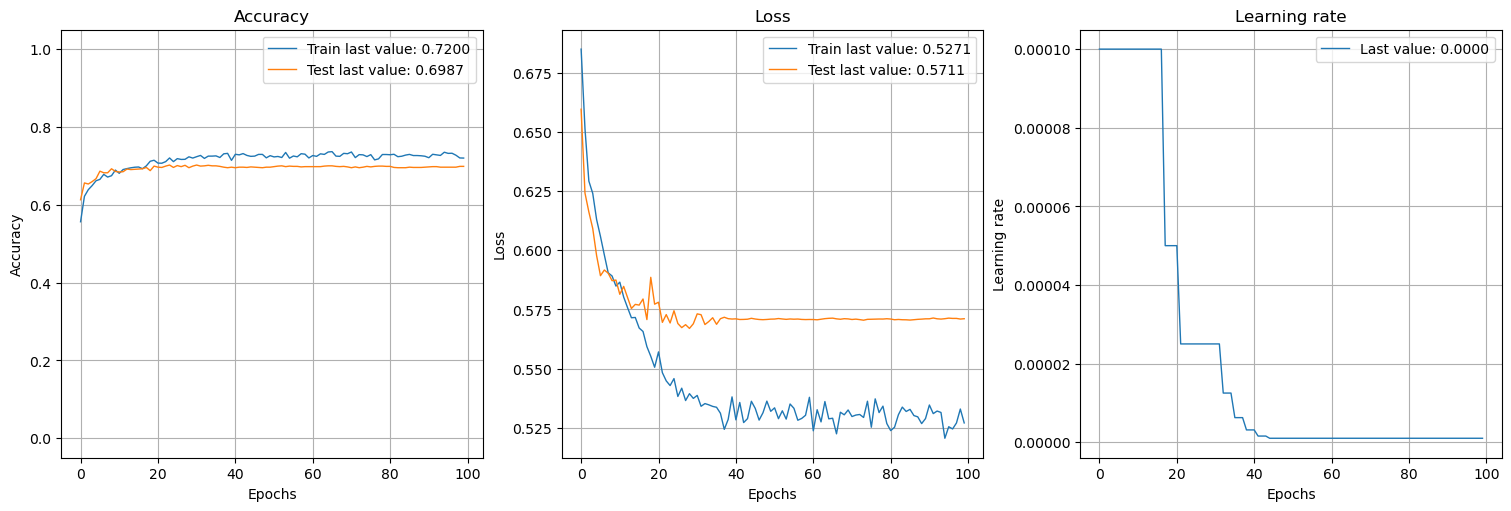

In [35]:
from plot_keras_history import plot_history
# Plot de l'historique de l'entra√Ænement
plot_history(history_W2v_tuned.history)

In [36]:
# Affichage des meilleurs hyperparam√®tres
print("Meilleurs hyperparam√®tres trouv√©s :")
print(f" - Units dans LSTM : {best_hps_W2v.get('units')}")
print(f" - Lambda de r√©gularisation L2 : {best_hps_W2v.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps_W2v.get('dropout_rate')}")
print(f" - Learning rate : {best_hps_W2v.get('learning_rate')}")

# Construire le meilleur mod√®le avec les meilleurs hyperparam√®tres
# Sp√©cifier l'input_shape correspondant √† tes donn√©es (par exemple `maxlen`)
input_shape = (maxlen,)  # Nombre max de tokens

# "Build" le mod√®le explicitement avec la taille d'entr√©e
best_model_W2v.build(input_shape=(None, *input_shape))  # None correspond √† la taille du batch

# Affichage du r√©sum√© du mod√®le
best_model_W2v.summary()

Meilleurs hyperparam√®tres trouv√©s :
 - Units dans LSTM : 384
 - Lambda de r√©gularisation L2 : 1.1095279439239067e-06
 - Dropout rate : 0.30000000000000004
 - Learning rate : 0.005059211234433455


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_1 (Embedding)              ‚îÇ (None, 40, 300)             ‚îÇ       1,832,700 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_1 (Bidirectional)      ‚îÇ (None, 768)                 ‚îÇ       2,104,320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                      ‚îÇ (None, 64)                  ‚îÇ          49,216 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)                  ‚îÇ (None, 64)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (None, 16)                  ‚îÇ           1,040 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)                  ‚îÇ (None, 16)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                      ‚îÇ (None, 1)                   ‚îÇ              17 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 8,296,481 (31.65 MB)

 Trainable params: 2,154,593 (8.22 MB)

 Non-trainable params: 1,832,700 (6.99 MB)

 Optimizer params: 4,309,188 (16.44 MB)

51/51 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 653ms/step


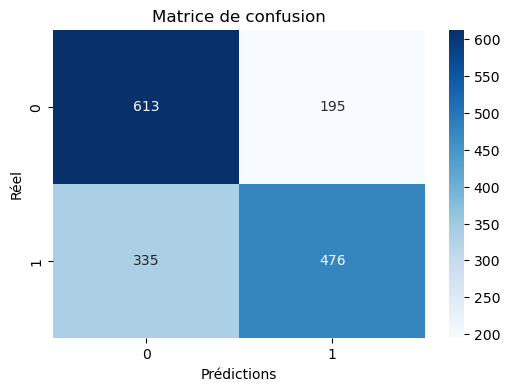

Rapport de classification :
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       808
           1       0.71      0.59      0.64       811

    accuracy                           0.67      1619
   macro avg       0.68      0.67      0.67      1619
weighted avg       0.68      0.67      0.67      1619



In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des pr√©dictions sur le jeu de test
y_pred_probs = best_model_W2v.predict(test_padded)  # Pr√©dictions en probabilit√©s
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Pr√©dictions')
plt.ylabel('R√©el')
# Sauvegarder l'image de la matrice de confusion
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


In [38]:
# Loguer le meilleur mod√®le et l'historique d'entra√Ænement dans MLflow 
with mlflow.start_run(run_name="best_model_W2v"):
    # Loguer les hyperparam√®tres
    mlflow.log_params(best_hps_W2v.values)
    
    # Loguer le mod√®le
    mlflow.keras.log_model(best_model_W2v, "model")
    
    # Loguer l'historique d'entra√Ænement (loss, accuracy, etc.)
    for epoch in range(len(history_W2v_tuned.history['loss'])):
        mlflow.log_metrics({
            'train_loss': history_W2v_tuned.history['loss'][epoch],
            'train_accuracy': history_W2v_tuned.history['accuracy'][epoch],
            'val_loss': history_W2v_tuned.history['val_loss'][epoch],
            'val_accuracy': history_W2v_tuned.history['val_accuracy'][epoch]
        }, step=epoch)
    # Loguer l'image de la matrice de confusion dans MLflow
    mlflow.log_artifact('confusion_matrix.png')
    # Loguer le rapport de classification sous forme de fichier texte
    with open('classification_report.txt', 'w') as f:
        f.write(class_report)    
    # Loguer le rapport de classification dans MLflow
    mlflow.log_artifact('classification_report.txt')

2024/11/13 08:17:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/13 08:17:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/13 08:17:37 INFO mlflow.tracking._tracking_service.client: üèÉ View run best_model_W2v at: http://localhost:5000/#/experiments/566106427225564143/runs/0d4af2b728724e4c9a2d9a930f49a048.
2024/11/13 08:17:37 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


# Glove

In [89]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Param√®tres
EMBEDDING_DIM = 200  # Dimension des embeddings Glove, ex: 50, 100, 200
MAX_NB_WORDS = 10000  # Limite de vocabulaire (nombre maximal de mots)
MAX_SEQUENCE_LENGTH = 40  # Longueur maximale des s√©quences de texte

# Charger les embeddings Glove
def load_glove_embedding(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'{len(embeddings_index)} mots vectoris√©s charg√©s depuis Glove.')
    return embeddings_index

# Chargement du fichier Glove twitter 27B (200)
glove_embeddings_index = load_glove_embedding('./Glove/glove.twitter.27B.200d.txt', EMBEDDING_DIM)

1193514 mots vectoris√©s charg√©s depuis Glove.


In [117]:
# Tokenizer - cr√©er un index pour chaque mot dans les donn√©es
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_df['preprocessed_text'].values)

# Convertir les textes en s√©quences
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed_text'].values)
val_sequences = tokenizer.texts_to_sequences(val_df['preprocessed_text'].values)
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed_text'].values)

# Appliquer le padding aux s√©quences pour les rendre de longueur √©gale
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Cr√©er la matrice d'embeddings
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))  # Nombre total de mots dans le tokenizer

embedding_matrix_glove = np.zeros((nb_words + 1, EMBEDDING_DIM))  # Ajouter +1 pour l'index 0 (padding)

for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector  # Si le mot est trouv√© dans Glove

print(f"Matrice d'embeddings cr√©√©e avec une dimension de {embedding_matrix_glove.shape}")

# Vos labels
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

Matrice d'embeddings cr√©√©e avec une dimension de (6141, 200)


In [93]:
import pandas as pd

# Convertir train_padded en DataFrame
train_glove = pd.DataFrame(train_padded)

# Ajouter la colonne 'target' √† train_glove
train_glove['target'] = train_df['target'].values

# Convertir test_padded en DataFrame
val_glove = pd.DataFrame(val_padded)

# Ajouter la colonne 'target' √† test_glove
val_glove['target'] = val_df['target'].values

# Sauvegarder les DataFrames dans des fichiers CSV
train_glove.to_csv('./data/train_glove.csv', index=False)
val_glove.to_csv('./data/val_glove.csv', index=False)


## Essai d'optimisation du mod√®le Glove

In [99]:
# Fonction de cr√©ation du mod√®le pour Keras Tuner avec embedding Glove
def build_model_glove(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec la matrice Glove pr√©-entra√Æn√©e
    model.add(Embedding(
        input_dim=embedding_matrix_glove.shape[0],     
        output_dim=embedding_matrix_glove.shape[1],         
        weights=[embedding_matrix_glove],          
        trainable=False              
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparam√®tres tunables
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='log')),  
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),  
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),
        return_sequences=False
    )))

    # 3. Couche de sortie Dense avec r√©gularisation L2
    model.add(Dense(
        units=1,                      
        activation='sigmoid',          
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))

    # Compilation du mod√®le
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [106]:
import os
import shutil
# Supprimer le r√©pertoire s'il existe d√©j√† (pour refaire une mise au point de param√®tres √† chaque run)
if os.path.exists('my_dir'):
    shutil.rmtree('my_dir')

# Instanciation du tuner apr√®s suppression
# Utilisation de RandomSearch pour garantir 40 epochs par essai et limiter le nombre d'essais
tuner_Glove = kt.RandomSearch(
    build_model_glove,
    objective='val_loss',
    max_trials=100,  # Ajustez le nombre total d'essais si besoin
    executions_per_trial=1,  
    directory='my_dir',
    project_name='tuning_Glove_fixed_epochs'
)

In [ ]:
# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparam√®tres avec le callback
tuner_Glove.search(
    train_padded, y_train,
    epochs=40,  # Fix√© √† 40 epochs
    validation_data=(val_padded, y_val),
    callbacks=[stop_early]
)

In [160]:
# R√©cup√©ration des meilleurs hyperparam√®tres
best_hps_Glove = tuner_Glove.get_best_hyperparameters(num_trials=1)[0]
best_model_Glove = tuner_Glove.hypermodel.build(best_hps_Glove)

In [161]:
# Param√®tres d'entrainement
n_epochs = 100
batch_size = 32
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial

In [162]:
# Entra√Æner le meilleur mod√®le avec ces hyperparam√®tres

from tensorflow.keras.callbacks import ModelCheckpoint

# D√©finir le callback ModelCheckpoint avec un nom sp√©cifique au mod√®le
checkpoint_callback = ModelCheckpoint(
    filepath='./models/best_model_Glove.weights.h5',  # fichier o√π les meilleurs poids sont sauvegard√©s
    monitor='val_loss',              # surveiller la validation loss
    mode='min',                      # rechercher le minimum de val_loss
    save_best_only=True,             # sauvegarder seulement les meilleurs poids
    save_weights_only=True,          # # sauvegarder seulement les poids pour les r√©cup√©rer rapidement
    verbose=1                        # afficher un message lorsque les meilleurs poids sont sauvegard√©s
)

# Entra√Ænement avec le callback ModelCheckpoint et MLflow
history_Glove_tuned = train_model_with_mlflow(
    model=best_model_Glove,
    train_data=train_padded,
    train_labels=y_train,
    validation_data=val_padded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="best_model_Glove",
    callbacks=[checkpoint_callback]  # Ajout du ModelCheckpoint
)

Epoch 1/100
105/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step - accuracy: 0.5283 - loss: 0.7002
Epoch 1: val_loss improved from inf to 0.68801, saving model to ./history/best_model.keras

Epoch 1: val_loss improved from inf to 0.68801, saving model to ./models/best_model_Glove.weights.h5
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 32ms/step - accuracy: 0.5285 - loss: 0.7002 - val_accuracy: 0.6078 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 2/100
105/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22ms/step - accuracy: 0.5988 - loss: 0.6863
Epoch 2: val_loss improved from 0.68801 to 0.67333, saving model to ./history/best_model.keras

Epoch 2: val_loss improved from 0.68801 to 0.67333, saving model to ./models/best_model_Glove.weights.h5
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 26ms/step - accuracy: 0.5988 - loss: 0.6863 - val_accuracy: 0.6257 - val_loss: 0.6733 - lear

2024/10/30 11:56:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 11:56:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/30 11:56:37 INFO mlflow.tracking._tracking_service.client: üèÉ View run best_model_Glove at: http://localhost:5000/#/experiments/566106427225564143/runs/3fd98621ee9242b1a9ad3cdb1ba9e85c.
2024/10/30 11:56:37 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

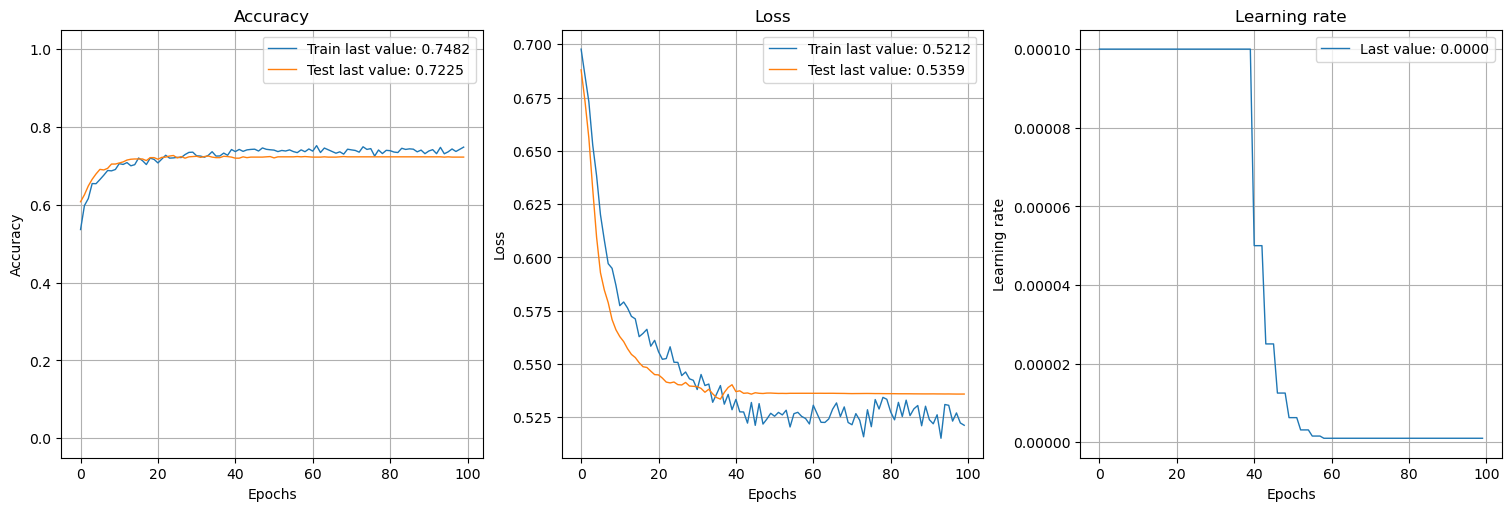

In [163]:
from plot_keras_history import plot_history
# Plot de l'historique de l'entra√Ænement
plot_history(history_Glove_tuned.history)

In [164]:
# Charger les meilleurs poids dans le mod√®le courant
best_model_Glove.load_weights('./models/best_model_Glove.weights.h5')

In [165]:
# Affichage des meilleurs hyperparam√®tres
print("Meilleurs hyperparam√®tres trouv√©s :")
print(f" - Units dans LSTM : {best_hps_Glove.get('units')}")
print(f" - Lambda de r√©gularisation L2 : {best_hps_Glove.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps_Glove.get('dropout_rate')}")
print(f" - Learning rate : {best_hps_Glove.get('learning_rate')}")

# Construire le meilleur mod√®le avec les meilleurs hyperparam√®tres
# Sp√©cifier l'input_shape correspondant √† tes donn√©es (par exemple `maxlen`)
input_shape = (MAX_SEQUENCE_LENGTH,)  # Nombre max de tokens

# "Build" le mod√®le explicitement avec la taille d'entr√©e
best_model_Glove.build(input_shape=(None, *input_shape))  # None correspond √† la taille du batch

# Affichage du r√©sum√© du mod√®le
best_model_Glove.summary()

Meilleurs hyperparam√®tres trouv√©s :
 - Units dans LSTM : 64
 - Lambda de r√©gularisation L2 : 1.6550986881455814e-05
 - Dropout rate : 0.4
 - Learning rate : 0.00012178790424045114


Model: "sequential_8"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_8 (Embedding)              ‚îÇ (None, 40, 200)             ‚îÇ       1,228,200 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_8 (Bidirectional)      ‚îÇ (None, 128)                 ‚îÇ         135,680 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                      ‚îÇ (None, 1)                   ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,635,629 (6.24 MB)

 Trainable params: 135,809 (530.50 KB)

 Non-trainable params: 1,228,200 (4.69 MB)

 Optimizer params: 271,620 (1.04 MB)

51/51 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step


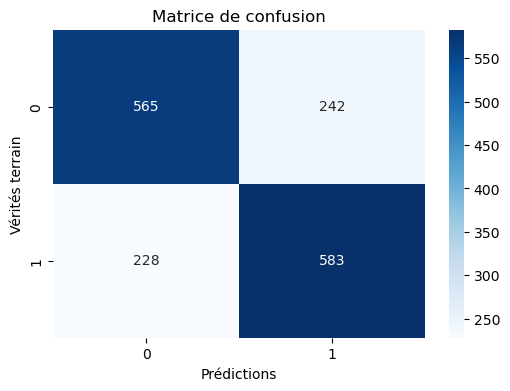

Rapport de classification :
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       807
           1       0.71      0.72      0.71       811

    accuracy                           0.71      1618
   macro avg       0.71      0.71      0.71      1618
weighted avg       0.71      0.71      0.71      1618



In [180]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des pr√©dictions sur le jeu de test
y_pred_probs = best_model_Glove.predict(test_padded)  # Pr√©dictions en probabilit√©s
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Pr√©dictions')
plt.ylabel('V√©rit√©s terrain')
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


### Log du mod√®le Glove optimis√© dans MLFlow

In [191]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Rechercher l'ID du run nomm√© "best_model_Glove" dans l'exp√©rience actuelle
# experiment_id = mlflow.get_experiment_by_name("mod√®le_avanc√©").experiment_id
runs = mlflow.search_runs(experiment_names=["modele_avanc√©"], filter_string="tags.mlflow.runName = 'best_model_Glove'")

# Si le run est trouv√©, on r√©cup√®re son ID, sinon on affiche un message d'erreur
if not runs.empty:
    existing_run_id = runs.iloc[0]["run_id"]

    # Ouvrir le run MLflow existant pour y ajouter les logs
    with mlflow.start_run(run_id=existing_run_id):
        
        # Visualisation et enregistrement du rapport de classification
        plt.figure(figsize=(10, 6))
        sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt="d", cmap="Blues")
        plt.title("Matrice de Confusion")
        plt.xlabel("Pr√©dictions")
        plt.ylabel("R√©el")
        plt.savefig('./history/confusion_matrix.png')
        mlflow.log_artifact('./history/confusion_matrix.png')
        plt.close()

        # Sauvegarder le rapport de classification en CSV et en texte
        class_report_df.to_csv('./history/classification_report.csv')
        mlflow.log_artifact('./history/classification_report.csv')
        mlflow.log_text(class_report_df.to_string(), "classification_report.txt")

else:
    print("Le run 'best_model_Glove' n'a pas √©t√© trouv√© dans l'exp√©rience sp√©cifi√©e.")


2024/10/30 16:01:34 INFO mlflow.tracking._tracking_service.client: üèÉ View run best_model_Glove at: http://localhost:5000/#/experiments/566106427225564143/runs/3fd98621ee9242b1a9ad3cdb1ba9e85c.
2024/10/30 16:01:34 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


# Mod√®le Bert

<font color="#FF0000">
    NETTOYAGE MEMOIRE ET CACHE DE CALCUL
______________________________________________________________________________________

In [108]:
import gc
# Lib√©rer les objets non r√©f√©renc√©s
gc.collect()
# Activer le garbage collector de TensorFlow pour GPU
from tensorflow.python.framework import ops
ops.reset_default_graph()
# Lib√©rer la m√©moire GPU utilis√©e par TensorFlow
import tensorflow as tf
tf.keras.backend.clear_session()

<font color="#FF0000">______________________________________________________________________________________

## R√©-entrainement de BertForSequenceClassification.from_pretrained associ√© √† un classifieur binaire (HuggingFace)

In [154]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd


In [5]:
# Colonnes utilis√©es par BERT
# train_df = train_df[['text', 'target']]
# test_df = test_df[['text', 'target']]
# val_df = val_df[['text', 'target']]
train_labels= train_df['target']
val_labels= val_df['target']
test_labels= test_df['target']

In [156]:
# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokeniser les textes
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_df['text']), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=64)

In [157]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# D√©finir la fonction compute_metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [158]:
# Cr√©ation d'un dataset PyTorch
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
val_dataset = TweetDataset(val_encodings, val_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())

In [159]:
training_args = TrainingArguments(
    output_dir='./results',          # o√π stocker les r√©sultats
    num_train_epochs=5,              # nombre d'√©poques
    per_device_train_batch_size=8,   # taille du batch pour l'entra√Ænement
    per_device_eval_batch_size=8,    # taille du batch pour l'√©valuation
    warmup_steps=500,                 # nombre d'√©tapes de warmup pour le scheduler
    weight_decay=0.01,                # taux de d√©croissance du poids
    logging_dir='./logs',            # r√©pertoire de logs
    logging_steps=10,
)


In [160]:
# Charger le mod√®le BERT pour la classification de s√©quence
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [162]:
# Initialiser le formateur
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
# Activer le suivi de MLflow pour le run principal
mlflow.start_run(run_name="Bert from pretrained")

# Cr√©ation d'un run imbriqu√© pour l'entra√Ænement
with mlflow.start_run(run_name="training", nested=True):
    # D√©marre l'entra√Ænement du mod√®le
    trainer.train()

üèÉ View run training at: http://localhost:5000/#/experiments/566106427225564143/runs/afa7f0342b9d4155954b220733d8462a
üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143


## Log de l'√©valuation durant l'entrainement

In [163]:
# √âvaluation
# Sous-run pour l'√©valuation
with mlflow.start_run(run_name="evaluation", nested=True):
    # √âvaluer le mod√®le sur les donn√©es de validation
    eval_results = trainer.evaluate(eval_dataset=val_dataset)

    # Logger les m√©triques d'√©valuation
    for metric, value in eval_results.items():
        mlflow.log_metric(metric, value)

üèÉ View run evaluation at: http://localhost:5000/#/experiments/566106427225564143/runs/cfbe6ee3f45341e0b693054e823b93df
üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143


## All√®gement du mod√®le

In [152]:
import torch
import torch.nn.utils.prune as prune
from torch.quantization import quantize_dynamic

# 1. D√©placer le mod√®le vers le CPU
trained_model = trainer.model.to('cpu')

# 2. Quantization dynamique
# La quantization dynamique est appliqu√©e sur les poids des couches de type Linear
quantized_model = quantize_dynamic(
    trained_model, 
    {torch.nn.Linear},  # Applique la quantization uniquement sur les couches Linear
    dtype=torch.qint8   # Type de quantization (par exemple, qint8 pour une quantization 8-bit)
)

# 3. Pruning des poids du mod√®le (par exemple, pruning des couches Linear)
# Pruning de 20% des poids dans les couches Linear
for name, module in quantized_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.2)  # Prune 20% des poids

# Afficher les r√©sultats pour v√©rifier le pruning
for name, module in quantized_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Pruned weights in {name}: {module.weight.shape}")

In [164]:
# Sauvegarder le mod√®le r√©sultant du Trainer dans le run principal
mlflow.pytorch.log_model(quantized_model, "model")

2024/11/21 10:34:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/21 10:34:46 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.19.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/21 10:34:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Predict sur le jeu de test (en testant le rechargement du mod√®le)

In [169]:
import torch
import mlflow
import mlflow.pytorch

# V√©rifier si CUDA est disponible et d√©finir le support de calcul, mais forcer l'utilisation du CPU
device = torch.device("cpu")  # Force l'utilisation du CPU

# Obtenir tous les runs
runs = mlflow.search_runs(filter_string="run_name = 'Bert from pretrained'")

# R√©cup√©rer l'ID du premier run correspondant (ou g√©rer les cas o√π il n'y en a pas)
if not runs.empty:
    run_id = runs.iloc[0].run_id
    model_path = "model"  # Chemin de l'artefact

    # Charger le mod√®le depuis le run sp√©cifi√©
    reloaded_model = mlflow.pytorch.load_model(f"runs:/{run_id}/{model_path}")

    # D√©placer le mod√®le explicitement sur le CPU
    reloaded_model.to(device)

    # V√©rifier que le mod√®le est charg√©
    print("Mod√®le charg√© avec succ√®s.")
else:
    print("Aucun run trouv√© avec le nom 'Bert from pretrained'.")


Mod√®le charg√© avec succ√®s.


In [170]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [171]:
def predict_all(texts, model):
    predictions = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64)
        
        # D√©placer les inputs vers le m√™me appareil que le mod√®le
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        with torch.no_grad():  # Pas besoin de calculer les gradients pour la pr√©diction
            outputs = model(**inputs)
        predictions.append(torch.argmax(outputs.logits, dim=1).item())
    return predictions

In [172]:
test_predictions= predict_all(test_df["text"], reloaded_model)

              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81       808
    Positive       0.81      0.81      0.81       811

    accuracy                           0.81      1619
   macro avg       0.81      0.81      0.81      1619
weighted avg       0.81      0.81      0.81      1619



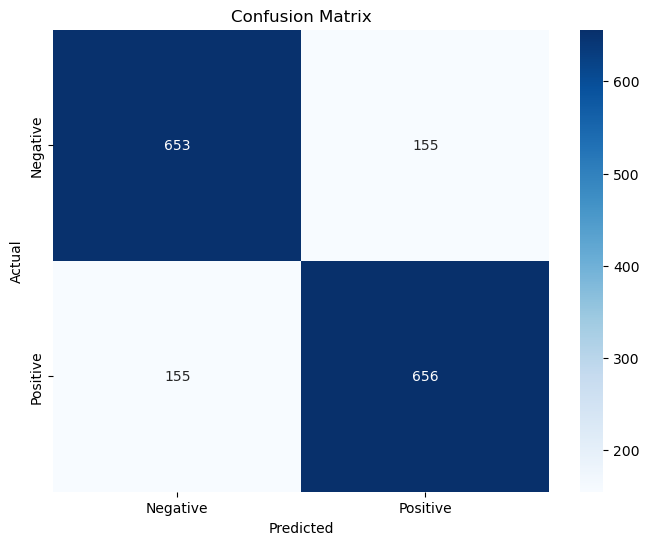

In [173]:
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

# Calculer le rapport de classification
classification_rep = classification_report(test_labels, test_predictions, target_names=["Negative", "Positive"])
print(classification_rep)

# Logger le rapport de classification dans MLflow
mlflow.log_text(classification_rep, "classification_report.txt")

# Calculer la matrice de confusion
cm = confusion_matrix(test_labels, test_predictions)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")  # Sauvegarder la matrice de confusion en tant qu'image
plt.show()

# Logger la matrice de confusion dans MLflow
mlflow.log_artifact("confusion_matrix.png")

# Supprimer les fichiers une fois logg√©s
os.remove("confusion_matrix.png")
# os.remove("classification_report.txt")


### Log du mod√®le complet wrapp√© avec signature (Bert_with_preprocessing)
Pour simplifier le script de l'API nous int√©grons la pr√©paration des donn√©es au mod√®le dans un mod√®le wrapper.

In [174]:
import mlflow.pyfunc
import torch
from transformers import BertTokenizer
import shutil
# shutil.rmtree("bert_with_preprocessing")


class BertWithPreprocessing(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        # Utilisation du mod√®le existant sans le recharger
        self.model = reloaded_model  # le mod√®le charg√© lors du test (all√©g√©)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.device = torch.device("cpu")  # Initialisation sur CPU par d√©faut

    def to(self, device):
        # D√©place le mod√®le sous-jacent vers le bon appareil
        self.device = device
        self.model.to(device)
    
    def predict(self, context, model_input):
        # G√©rer diff√©rents types de structures pour `model_input`
        if isinstance(model_input, pd.DataFrame):
            text = model_input["text"].iloc[0]  # Prendre la premi√®re ligne du DataFrame (une seule phrase)
        elif isinstance(model_input, list):
            text = model_input[0]  # Utiliser directement la premi√®re phrase de la liste
        elif isinstance(model_input, str):
            text = model_input  # Si c'est d√©j√† une cha√Æne, l'utiliser directement
        else:
            raise ValueError("Le format de `model_input` n'est pas support√©.")
        
        # Pr√©traitement de la phrase
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        )
        
        # D√©placer les inputs sur le bon appareil
        inputs = {key: tensor.to(self.device) for key, tensor in inputs.items()}
        
        # Pr√©diction
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Assurez-vous que les pr√©dictions soient renvoy√©es sur le CPU pour compatibilit√© avec numpy
        
        return predictions


# D√©marrer le run et enregistrer le mod√®le dans l'exp√©rience et le run en cours
with mlflow.start_run(run_name="Bert_with_preprocessing", nested=True) as run:
    bert_model = BertWithPreprocessing()
    mlflow.pyfunc.log_model(artifact_path="bert_with_preprocessing", python_model=bert_model)

2024/11/21 10:46:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.19.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/21 10:46:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Bert_with_preprocessing at: http://localhost:5000/#/experiments/566106427225564143/runs/6c81f9e94e4f482baad29a41ec53aebf
üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143


In [175]:
# D√©placer le mod√®le sur le CPU car l'ex√©cution sur GPU n'est pas requise
bert_model.load_context(context=None)  # Charger le mod√®le dans self.model
device = torch.device("cpu")  #"cuda" if torch.cuda.is_available() else 
bert_model.to(device)

In [176]:
print("Le mod√®le est sur :", next(bert_model.model.parameters()).device)

Le mod√®le est sur : cpu


In [177]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
import mlflow

# Exemple d'entr√©e pour le mod√®le
# Utilisez une seule phrase pour l'exemple
INPUT_EXAMPLE = ["I love machine learning!"]

# Signature d'entr√©e
input_schema = Schema([ColSpec("string", "text")])  # Changez 'texts' en 'text'
output_schema = Schema([ColSpec("integer")])  # Le mod√®le retourne une pr√©diction enti√®re
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

# R√©cup√©rez l'ID du run actuel
current_run_id = mlflow.active_run().info.run_id

# Compl√©ter les artifacts logg√©s sous ce run existant
with mlflow.start_run(run_id=current_run_id, nested=True):
    mlflow.pyfunc.log_model(
        artifact_path="complete_bert_with_preprocessing",
        python_model=bert_model,  # Le mod√®le doit √™tre votre objet 'BertWithPreprocessing'
        signature=signature,
        input_example=INPUT_EXAMPLE
    )


2024/11/21 10:48:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.19.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.19.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


üèÉ View run Bert from pretrained at: http://localhost:5000/#/experiments/566106427225564143/runs/e2b22363be6a427a8bdad0ad7cbc8584
üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143


### Validation du mod√®le logg√© (code fourni par MLFlow)

In [178]:
from mlflow.models import validate_serving_input

model_uri = 'runs:/e2b22363be6a427a8bdad0ad7cbc8584/complete_bert_with_preprocessing'

# The model is logged with an input example. MLflow converts
# it into the serving payload format for the deployed model endpoint,
# and saves it to 'serving_input_payload.json'
serving_payload = """{
  "inputs": [
    "I love machine learning!"
  ]
}"""

# Validate the serving payload works on the model
validate_serving_input(model_uri, serving_payload)

array([0], dtype=int64)

In [179]:
# Test du mod√®le avec pre-processing
import pandas as pd
import mlflow

# Charger le mod√®le avec sch√©ma et signature
logged_model = model_uri
loaded_model = mlflow.pyfunc.load_model(logged_model)

# √âchantillonner 1 ligne al√©atoire de la colonne "text" de test_df
data = test_df[['text']].sample(1).reset_index(drop=True)

# Effectuer la pr√©diction
predictions = loaded_model.predict(data)

# Afficher la phrase et le sentiment en fonction de la pr√©diction
for i, pred in enumerate(predictions):
    print(f"Phrase: {data.iloc[i]['text']}")
    if pred == 1:
        print("Sentiment n√©gatif")
    else:
        print("Sentiment postif")


Phrase: I'm so sad about the Air France Jet crash. It's crazy, the plane just disappeared. Poor travelers...  http://is.gd/LKkT
Sentiment n√©gatif


In [180]:
# Test du predict avec une phrase nouvelle

# Exemple d'entr√©e sous forme de cha√Æne
sentence = "My baggage was damaged and the airline took no responsibility for it."

# Ou sous forme de DataFrame (1 phrase)
import pandas as pd
data = pd.DataFrame({"text": [sentence]})

# Effectuer la pr√©diction
predictions = loaded_model.predict(data)

# Affichage du sentiment bas√© sur la pr√©diction
for pred in predictions:
    if pred == 0:
        print("Sentiment : positif")
    else:
        print("Sentiment : n√©gatif")

Sentiment : n√©gatif


### Enregistrement du mod√®le logg√©

In [181]:
# Enregistrer le mod√®le dans le Model Registry local
import mlflow

# Nom du mod√®le dans le Model Registry
model_name = "BertModelSequenceClassificationFromPretrained"

# Enregistrement du mod√®le dans le registre sous le nom sp√©cifi√©
model_version = mlflow.register_model(model_uri=model_uri, name=model_name)

# Ajout de l'alias "champion" √† la derni√®re version du mod√®le
client = mlflow.tracking.MlflowClient()
client.set_registered_model_alias(name=model_name, alias="champion", version=model_version.version)

print(f"Mod√®le enregistr√© avec succ√®s sous le nom '{model_name}' avec l'alias 'champion'.")

Registered model 'BertModelSequenceClassificationFromPretrained' already exists. Creating a new version of this model...
2024/11/21 10:51:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: BertModelSequenceClassificationFromPretrained, version 3


Mod√®le enregistr√© avec succ√®s sous le nom 'BertModelSequenceClassificationFromPretrained' avec l'alias 'champion'.


Created version '3' of model 'BertModelSequenceClassificationFromPretrained'.


In [182]:
# Terminer le run
mlflow.end_run()

üèÉ View run Bert from pretrained at: http://localhost:5000/#/experiments/566106427225564143/runs/e2b22363be6a427a8bdad0ad7cbc8584
üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143


### Sauvegarde du mod√®le sur Azure Blob

In [183]:
import mlflow
import os
import shutil

# URI du mod√®le dans le Model Registry
model_name = "BertModelSequenceClassificationFromPretrained"
model_version = "3"
model_uri = f"models:/{model_name}/{model_version}"

# R√©pertoire local pour enregistrer le mod√®le
model_dir = "./model_temp"  # R√©pertoire temporaire

# Supprimer le r√©pertoire s'il existe d√©j√†
if os.path.exists(model_dir):
    shutil.rmtree(model_dir)

# T√©l√©charger le mod√®le depuis MLflow
mlflow.artifacts.download_artifacts(artifact_uri=model_uri, dst_path=model_dir)

print(f"Mod√®le t√©l√©charg√© en local sous {model_dir}")


Mod√®le t√©l√©charg√© en local sous ./model_temp


In [184]:
from azure.storage.blob import BlobServiceClient
import os
import shutil

# Cha√Æne de connexion Azure Storage
storage_connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
container_name = "oc-p7-modeles"

# Initialiser le client de service Blob
blob_service_client = BlobServiceClient.from_connection_string(storage_connection_string)

# Chemin du r√©pertoire contenant le mod√®le
local_model_path = model_dir

# Upload des fichiers du mod√®le
for root, dirs, files in os.walk(local_model_path):
    for file_name in files:
        # Chemin local du fichier
        file_path = os.path.join(root, file_name)

        # Chemin dans le container Azure Blob
        blob_name = os.path.relpath(file_path, local_model_path)
        blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

        # Upload du fichier
        with open(file_path, "rb") as data:
            blob_client.upload_blob(data, overwrite=True)

print(f"Mod√®le upload√© dans le container Azure Blob '{container_name}'.")

# Suppression du dossier local apr√®s l'upload
try:
    # V√©rifie si le dossier existe
    if os.path.exists(local_model_path) and os.path.isdir(local_model_path):
        # Suppression r√©cursive du r√©pertoire et de son contenu
        shutil.rmtree(local_model_path)
        print(f"Dossier local '{local_model_path}' supprim√©.")
    else:
        print(f"Le dossier local '{local_model_path}' n'existe pas.")
except Exception as e:
    print(f"Erreur lors de la suppression du dossier local : {e}")


Mod√®le upload√© dans le container Azure Blob 'oc-p7-modeles'.
Dossier local './model_temp' supprim√©.


## Classification depuis un embedding Bert

In [6]:
import torch
from transformers import BertTokenizer, BertModel
import pandas as pd

In [7]:
# Charger le tokenizer et le mod√®le BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# D√©finir l'appareil (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [9]:
import numpy as np
# Production des embeddings
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        # Tokeniser le texte
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

        # Obtenir les embeddings
        with torch.no_grad():  # Pas besoin de calculer les gradients
            outputs = model(**inputs)
        
        # Les embeddings de la derni√®re couche cach√©e
        last_hidden_states = outputs.last_hidden_state
        
        # Prendre la moyenne des embeddings sur la dimension des tokens
        pooled_output = last_hidden_states.mean(dim=1).cpu().numpy()  # Convertion en numpy pour faciliter l'utilisation
        embeddings.append(pooled_output)

    return np.vstack(embeddings)  # Retourner un tableau numpy 2D

# Produire des embeddings pour les tweets
bert_embeddings = get_bert_embeddings(tweets_df['text'])

In [10]:
# Transformer les embeddings en DataFrame
bert_embeddings_df = pd.DataFrame(bert_embeddings)
bert_embeddings_df['target'] = tweets_df['target'].values

# Sauvegarder le DataFrame en fichier CSV dans ./data => AutoML
bert_embeddings_df.to_csv('./data/bert_embeddings.csv', index=False)

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Pour ce test rapide on prend le dataset complet puis train/test split
target = tweets_df['target'].values
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, target, test_size=0.2, random_state=42)

# D√©finir les classifieurs
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
}

# Tester chaque classifieur
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       639
           1       0.78      0.75      0.77       656

    accuracy                           0.77      1295
   macro avg       0.77      0.77      0.77      1295
weighted avg       0.77      0.77      0.77      1295

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70       639
           1       0.71      0.71      0.71       656

    accuracy                           0.71      1295
   macro avg       0.71      0.71      0.71      1295
weighted avg       0.71      0.71      0.71      1295

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78       639
           1       0.79      0.75      0.77       656

    accuracy                           0.77      1295
   mac

C:\Users\cecil\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.73      0.74      0.73       639
           1       0.74      0.73      0.74       656

    accuracy                           0.74      1295
   macro avg       0.74      0.74      0.74      1295
weighted avg       0.74      0.74      0.74      1295

[LightGBM] [Info] Number of positive: 2588, number of negative: 2590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5178, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499807 -> initscore=-0.000772
[LightGBM] [Info] Start training from score -0.000772
Classification Report for LightGBM:
               precision    recall  f1-score   support

           0       0.73      0.74      0.73       6

De fa√ßon imm√©diate la r√©gression logistique ou SVM produisent une classification avec 77% d'exactitude. AutoML fait l√©g√®rement mieux 0.777 avec un mod√®le d'ensemble stack√© <br>
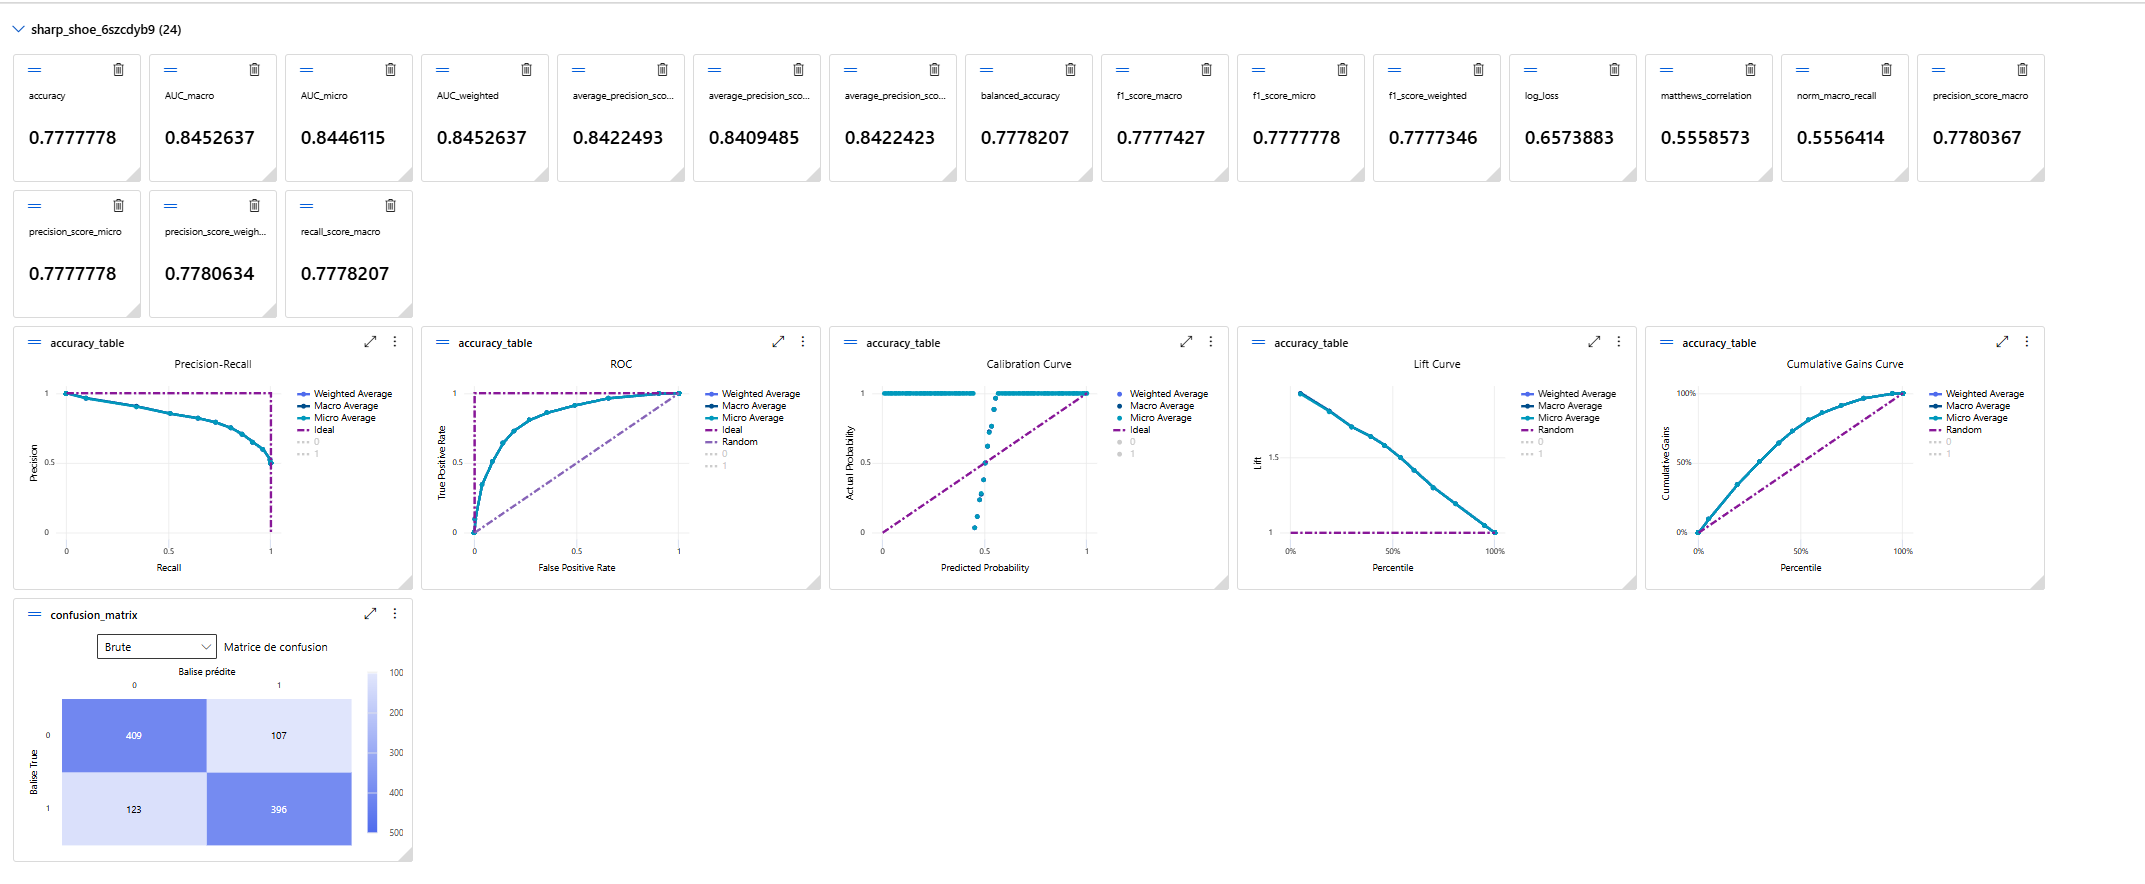

### Optimisation d'une r√©gression logistique
L'int√©r√™t est de comparer les r√©sultats de r√©gression logistique obtenus depuis un embedding par comptage (TfIdF avait donn√© les meilleurs r√©sultats) par rapport √† l'embedding de Bert.

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd 

# Charger les donn√©es
X = bert_embeddings_df.drop(columns=["target"])
y = bert_embeddings_df["target"]

def objective(trial):
    # D√©finir les hyperparam√®tres √† optimiser
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    penalty = 'l2' if solver == 'lbfgs' else trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    # Cr√©er et entra√Æner le mod√®le
    model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=1000)
    # Utiliser la validation crois√©e pour √©valuer les performances
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    
    return accuracy

# Initialiser et ex√©cuter l'optimisation Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Meilleurs param√®tres et meilleure performance
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Entra√Æner le mod√®le final avec les meilleurs param√®tres
best_model_lr_Bert_embedding = LogisticRegression(**study.best_params, max_iter=1000)
best_model_lr_Bert_embedding.fit(X, y)


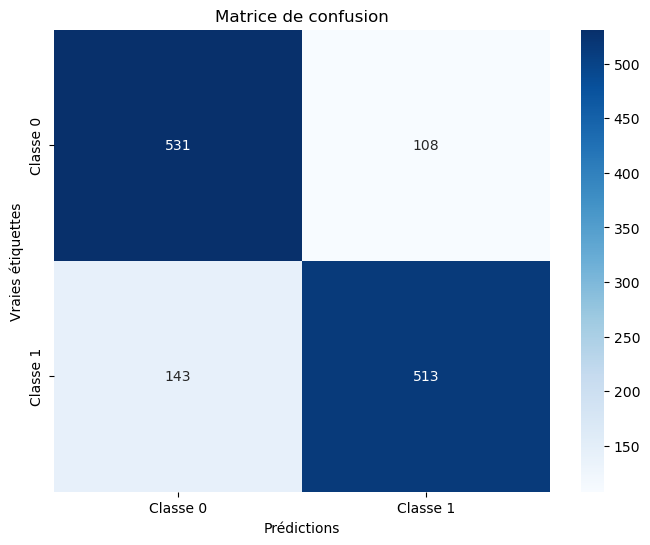

Rapport de classification:
               precision    recall  f1-score   support

    Classe 0       0.79      0.83      0.81       639
    Classe 1       0.83      0.78      0.80       656

    accuracy                           0.81      1295
   macro avg       0.81      0.81      0.81      1295
weighted avg       0.81      0.81      0.81      1295



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Pr√©dictions sur les donn√©es de test
y_pred = best_model_lr_Bert_embedding.predict(X_test)

# G√©n√©rer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Pr√©dictions")
plt.ylabel("Vraies √©tiquettes")
plt.title("Matrice de confusion")
plt.show()

# Afficher le rapport de classification
report = classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"])
print("Rapport de classification:\n", report)


On arrive √† gagner 10% d'accuracy par rapport √† une r√©gression logistique depuis un embedding par comptage. Il est √©galement int√©ressant de voir que les performances de ce mod√®le sont √©quivalentes √† celle du mod√®le Bert r√©-entrain√©. Le classifieur est tr√®s simple, rapide et efficace ; meilleur que celui mis au point par AutoML.

### Log du mod√®le Classification with Bert Embedding

In [47]:
mlflow.end_run()

üèÉ View run Classification with Bert embedding at: http://localhost:5000/#/experiments/566106427225564143/runs/1b1c696e43ce4514848049c11431be24
üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143


In [48]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# D√©marrer un nouveau run MLflow
mlflow.start_run(run_name="Classification with Bert embedding")

# Logger les meilleurs param√®tres
mlflow.log_params(study.best_params)

# Logger le mod√®le entra√Æn√©
mlflow.sklearn.log_model(best_model_lr_Bert_embedding, "model")

# Pr√©dictions sur le jeu de test
y_pred = best_model_lr_Bert_embedding.predict(X_test)

# Calculer les m√©triques
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"], output_dict=True)

# Logger les m√©triques principales
mlflow.log_metric("accuracy", accuracy)
mlflow.log_metric("precision_classe_0", report["Classe 0"]["precision"])
mlflow.log_metric("recall_classe_0", report["Classe 0"]["recall"])
mlflow.log_metric("f1_classe_0", report["Classe 0"]["f1-score"])
mlflow.log_metric("precision_classe_1", report["Classe 1"]["precision"])
mlflow.log_metric("recall_classe_1", report["Classe 1"]["recall"])
mlflow.log_metric("f1_classe_1", report["Classe 1"]["f1-score"])

# G√©n√©rer et sauvegarder la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Pr√©dictions")
plt.ylabel("Vraies √©tiquettes")
plt.title("Matrice de confusion")
conf_matrix_path = "./confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.close()

# Logger la matrice de confusion
mlflow.log_artifact(conf_matrix_path)

# Logger le rapport de classification en texte
report_path = "./classification_report.txt"
with open(report_path, "w") as f:
    f.write(classification_report(y_test, y_pred, target_names=["Classe 0", "Classe 1"]))
mlflow.log_artifact(report_path)

# D√©finir un exemple d'entr√©e et de sortie pour la signature
input_example = np.array(X_test[0]).reshape(1, -1).astype(np.float32)  # Exemple d'entr√©e √† partir de X_test
output_example = np.array([y_pred[0]]).astype(np.int32)  # Exemple de sortie correspondant √† l'exemple d'entr√©e

# Cr√©er une signature de mod√®le
signature = mlflow.models.signature.infer_signature(input_example, output_example)

# Logger le mod√®le avec la signature et l'exemple d'entr√©e
mlflow.sklearn.log_model(best_model_lr_Bert_embedding, "model", signature=signature, input_example=input_example)

# Nettoyer les fichiers temporaires
os.remove(conf_matrix_path)
os.remove(report_path)

# Le run reste actif ici. Ajoutez vos instructions suppl√©mentaires si n√©cessaire.

# Fin du run (peut √™tre appel√©e plus tard)
# mlflow.end_run()


2024/11/21 21:07:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Classification par r√©seau de neurones depuis l'embedding de Bert
Nous allons mettre en oeuvre le r√©seau complexe (LSTM bidirectionnel avec r√©gularisation) d√©velopp√© pour WordtoVec et Glove.

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.regularizers import l2

# Instanciation du mod√®le s√©quentiel
model_BERT_embedding = Sequential()

# Ajout de la couche d'entr√©e avec une dimension suppl√©mentaire
model_BERT_embedding.add(Input(shape=(X.shape[1],)))  # X.shape[1] correspond √† la taille de l'embedding BERT
model_BERT_embedding.add(Reshape((1, X.shape[1])))    # Reshape pour ajouter la dimension "timesteps" attendue par LSTM

# Ajout d'une couche LSTM bidirectionnelle avec r√©gularisation L2
model_BERT_embedding.add(Bidirectional(LSTM(128)))   #, kernel_regularizer=l2(0.01)

# Ajout d'une couche Dropout pour √©viter le sur-ajustement
model_BERT_embedding.add(Dropout(0.8))

# Optionnel : Ajout d'une couche dense pour r√©duire la complexit√© du mod√®le
model_BERT_embedding.add(Dense(64, activation='relu'))
model_BERT_embedding.add(Dropout(0.5))

# Ajout d'une couche de sortie pour la classification binaire
model_BERT_embedding.add(Dense(1, activation='sigmoid'))

# Compilation du mod√®le
model_BERT_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage de la structure du mod√®le
model_BERT_embedding.summary()


Model: "sequential_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ reshape_3 (Reshape)                  ‚îÇ (None, 1, 768)              ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_5 (Bidirectional)      ‚îÇ (None, 256)                 ‚îÇ         918,528 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout)                  ‚îÇ (None, 256)                 ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                      ‚îÇ (None, 64)                  ‚îÇ          16,448 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_9 (Dropout)                  ‚îÇ (None, 64)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                      ‚îÇ (None, 1)                   ‚îÇ              65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 935,041 (3.57 MB)

 Trainable params: 935,041 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Param√®tres d'entrainement communs
n_epochs = 50
batch_size = 16
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial

In [94]:
# Appel de la fonction d'entra√Ænement avec MLflow
history_BERT_embedding = train_model_with_mlflow(
    model=model_BERT_embedding,
    train_data=X_train,
    train_labels=y_train,
    validation_data=X_test,
    validation_labels=y_test,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="training_model_BERT_embedding_BLSTM128"
)


Epoch 1/50
312/324 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - accuracy: 0.5280 - loss: 0.6965
Epoch 1: val_loss improved from inf to 0.63939, saving model to ./history/best_model.keras
324/324 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 5ms/step - accuracy: 0.5291 - loss: 0.6960 - val_accuracy: 0.6708 - val_loss: 0.6394 - learning_rate: 1.0000e-04
Epoch 2/50
316/324 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step - accuracy: 0.6365 - loss: 0.6427
Epoch 2: val_loss improved from 0.63939 to 0.58110, saving model to ./history/best_model.keras
324/324 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - accuracy: 0.6369 - loss: 0.6423 - val_accuracy: 0.7048 - val_loss: 0.5811 - learning_rate: 1.0000e-04
Epoch 3/50
318/324 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step - accuracy: 0.6705 - loss: 0.6052
Epoch 3: val_loss improved from 0.58110 to 0.55038, saving model t

2024/11/02 11:05:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/02 11:06:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


162/162 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step


2024/11/02 11:06:13 INFO mlflow.tracking._tracking_service.client: üèÉ View run training_model_BERT_embedding_BLSTM128 at: http://localhost:5000/#/experiments/566106427225564143/runs/a412c4f83deb4378ba85920e91dc7232.
2024/11/02 11:06:13 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Le gain d'un r√©seau de neurones n'est pas prouv√©, le temps d'entrainement est beaucoup plus important qu'une r√©gression logistique.

## Fine-tuning Bert (HuggingFace)

In [96]:
# Test de fonctionnement du GPU
import torch

# V√©rifie si un GPU est disponible
if torch.cuda.is_available():
    print("Le GPU est activ√© et sera utilis√©.")
else:
    print("Pas de GPU disponible, utilisation du CPU.")


Le GPU est activ√© et sera utilis√©.


In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Charger tes donn√©es
tweets_df = pd.read_csv("./data/data_autoML.csv")

# Diviser en ensembles d'entra√Ænement et de test
train_df, test_df = train_test_split(tweets_df, test_size=0.2, random_state=42)

# Cr√©er des datasets √† partir des DataFrames avec les √©tiquettes
train_dataset = Dataset.from_pandas(train_df[['text', 'target']])
test_dataset = Dataset.from_pandas(test_df[['text', 'target']])

# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokeniser les textes
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Renommer la colonne des √©tiquettes
train_dataset = train_dataset.rename_column("target", "labels")
test_dataset = test_dataset.rename_column("target", "labels")

# Charger le mod√®le BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# D√©finir les arguments d'entra√Ænement
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Cr√©er un Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Lancer l'entra√Ænement
trainer.train()


Map:   0%|          | 0/5175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1294 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\envs\AIEP7\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


2024/11/02 11:27:23 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 94e1767130864eecb93037c25dec0e99: Failed to log run data: Exception: API request to http://localhost:5000/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


TrainOutput(global_step=972, training_loss=0.3406699616232036, metrics={'train_runtime': 6090.7157, 'train_samples_per_second': 2.549, 'train_steps_per_second': 0.16, 'total_flos': 4084799134464000.0, 'train_loss': 0.3406699616232036, 'epoch': 3.0})

In [102]:
# Sauvegarder le mod√®le
trainer.save_model("./models/BERT_retrained")


In [103]:
from transformers import BertForSequenceClassification

# Charger le mod√®le
model_BERT_retrained = BertForSequenceClassification.from_pretrained("./models/BERT_retrained")


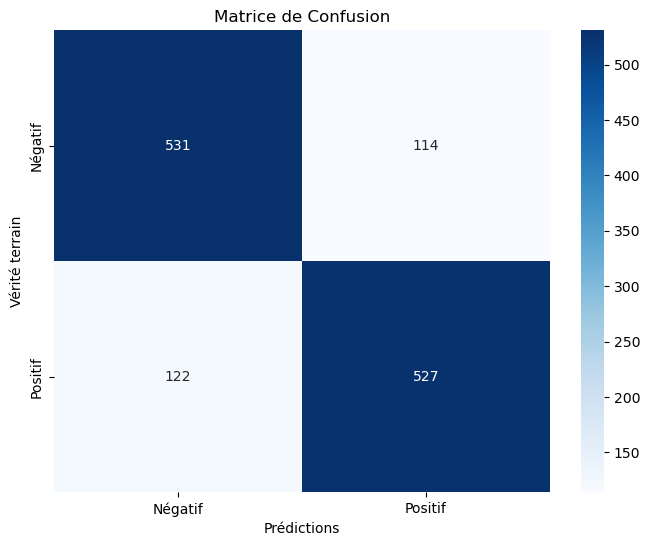

Rapport de Classification:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       645
           1       0.82      0.81      0.82       649

    accuracy                           0.82      1294
   macro avg       0.82      0.82      0.82      1294
weighted avg       0.82      0.82      0.82      1294



In [107]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# V√©rifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transf√©rer le mod√®le sur le GPU si disponible
model_BERT_retrained.to(device)
model_BERT_retrained.eval()

# 1. Charger les donn√©es de test et obtenir les √©tiquettes
labels = test_dataset["labels"]

# Cr√©er une liste pour stocker les pr√©dictions
predictions = []

# 2. Effectuer les pr√©dictions batch par batch pour √©viter les d√©passements de m√©moire
for i in range(0, len(test_dataset), 32):  # Utilise un batch size de 32 pour chaque sous-ensemble
    # S√©lectionner un batch de donn√©es
    batch = test_dataset.select(range(i, min(i + 32, len(test_dataset))))
    
    # Transf√©rer les tenseurs d'entr√©e sur le m√™me appareil que le mod√®le
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    with torch.no_grad():
        outputs = model_BERT_retrained(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()  # Transf√©rer les pr√©dictions sur CPU pour faciliter l'analyse
        predictions.extend(batch_predictions)

# Convertir les listes en numpy arrays pour calculer les m√©triques
predictions = np.array(predictions)
labels = np.array(labels)

# 3. Calculer la matrice de confusion et le rapport de classification
conf_matrix = confusion_matrix(labels, predictions)
class_report = classification_report(labels, predictions)

# 4. Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['N√©gatif', 'Positif'], yticklabels=['N√©gatif', 'Positif'])
plt.ylabel('V√©rit√© terrain')
plt.xlabel('Pr√©dictions')
plt.title('Matrice de Confusion')
plt.show()

# 5. Afficher le rapport de classification
print("Rapport de Classification:\n", class_report)


C'est le meilleur mod√®le, avec des pr√©dictions aussi bonnes sur la classe positive que n√©gative. Par contre le temps d'entrainement a √©t√© de 1h40 pour 5175 exemples. 

# Universal Sentence Encoder (USE)

## Pr√©paration des donn√©es

In [197]:
import tensorflow_hub as hub
import shutil
import tempfile

# Acc√©der au r√©pertoire de cache par d√©faut de TensorFlow Hub
cache_dir = tempfile.gettempdir() + "/tfhub_modules"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)  # Supprime le cache pour forcer le t√©l√©chargement

In [198]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from mlflow.models import infer_signature

# Charger le mod√®le USE depuis TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Fonction pour transformer les textes en embeddings avec USE
def embed_text(texts):
    return use_model(texts).numpy()  # Convertir en numpy array

# Charger les datasets (train_df et test_df d√©j√† s√©par√©s)
X_train = train_df['text'].values
y_train = train_df['target'].values
X_val = val_df['text'].values
y_val = val_df['target'].values
X_test = test_df['text'].values
y_test = test_df['target'].values

# Convertir le texte en embeddings
X_train_embedded = embed_text(X_train)
X_val_embedded = embed_text(X_val)
X_test_embedded = embed_text(X_test)

### Construction d'une architecture de mod√®le

In [202]:
# Construire le mod√®le simple avec TensorFlow
model_use = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train_embedded.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Pour classification binaire
])
model_use.summary()
# # Compiler le mod√®le
# model.compile(optimizer='adam',
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])

# # D√©marrer un run MLflow
# with mlflow.start_run(run_name="USE"):
#     # Entra√Æner le mod√®le
#     history = model.fit(X_train_embedded, y_train, epochs=30, batch_size=32, validation_data=(X_test_embedded, y_test))

#     # √âvaluer le mod√®le
#     y_pred = (model.predict(X_test_embedded) > 0.5).astype("int32")
#     accuracy = accuracy_score(y_test, y_pred)

#     # Log des m√©triques
#     mlflow.log_metric("accuracy", accuracy)

#     # Cr√©er la signature du mod√®le
#     signature = infer_signature(X_train_embedded, model.predict(X_train_embedded))

#     # Log du mod√®le avec signature
#     mlflow.tensorflow.log_model(model, "model", signature=signature)

#     # Log de la classification report
#     class_report = classification_report(y_test, y_pred, output_dict=True)
#     for label, metrics in class_report.items():
#         if isinstance(metrics, dict):  # V√©rifier si metrics est un dictionnaire
#             mlflow.log_metrics({f"{label}_{metric}": value for metric, value in metrics.items() if metric != 'support'})

#     # Produire et logger la matrice de confusion
#     cm = confusion_matrix(y_test, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()
#     plt.title("Matrice de confusion")
#     plt.savefig("confusion_matrix.png")
#     plt.close()
#     mlflow.log_artifact("confusion_matrix.png")

Model: "sequential_12"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ dense_15 (Dense)                     ‚îÇ (None, 128)                 ‚îÇ          65,664 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)                  ‚îÇ (None, 128)                 ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_16 (Dense)                     ‚îÇ (None, 1)                   ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 65,793 (257.00 KB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 0 (0.00 B)

### Entrainement

In [203]:
# Param√®tres d'entrainement
n_epochs = 100
batch_size = 32
# D√©finir les hyperparam√®tres de l'entra√Ænement
initial_learning_rate = 0.0001  # Apprentissage initial

In [204]:
# Entra√Æner le meilleur mod√®le avec ces hyperparam√®tres

from tensorflow.keras.callbacks import ModelCheckpoint

# D√©finir le callback ModelCheckpoint avec un nom sp√©cifique au mod√®le
checkpoint_callback = ModelCheckpoint(
    filepath='./models/model_Use.weights.h5',  # fichier o√π les meilleurs poids sont sauvegard√©s
    monitor='val_loss',              # surveiller la validation loss
    mode='min',                      # rechercher le minimum de val_loss
    save_best_only=True,             # sauvegarder seulement les meilleurs poids
    save_weights_only=True,          # # sauvegarder seulement les poids pour les r√©cup√©rer rapidement
    verbose=1                        # afficher un message lorsque les meilleurs poids sont sauvegard√©s
)

# Entra√Ænement avec le callback ModelCheckpoint et MLflow
history_Glove_tuned = train_model_with_mlflow(
    model=model_use,
    train_data=X_train_embedded,
    train_labels=y_train,
    validation_data=X_val_embedded,
    validation_labels=y_val,
    epochs=n_epochs,
    batch_size=batch_size,
    learning_rate=initial_learning_rate,
    run_name="USE",
    callbacks=[checkpoint_callback]  # Ajout du ModelCheckpoint
)

Epoch 1/100
 84/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step - accuracy: 0.4952 - loss: 0.6938
Epoch 1: val_loss improved from inf to 0.68211, saving model to ./history/best_model.keras

Epoch 1: val_loss improved from inf to 0.68211, saving model to ./models/model_Use.weights.h5
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - accuracy: 0.5055 - loss: 0.6929 - val_accuracy: 0.6449 - val_loss: 0.6821 - learning_rate: 1.0000e-04
Epoch 2/100
 59/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 879us/step - accuracy: 0.6143 - loss: 0.6815
Epoch 2: val_loss improved from 0.68211 to 0.66968, saving model to ./history/best_model.keras

Epoch 2: val_loss improved from 0.68211 to 0.66968, saving model to ./models/model_Use.weights.h5
107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - accuracy: 0.6240 - loss: 0.6803 - val_accuracy: 0.7040 - val_loss: 0.6697 - learning_rate: 1.000

2024/10/30 18:37:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/30 18:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


107/107 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 905us/step


2024/10/30 18:37:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\cecil\AppData\Local\Temp\tmphwwxbf13\model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/10/30 18:37:43 INFO mlflow.tracking._tracking_service.client: üèÉ View run USE at: http://localhost:5000/#/experiments/566106427225564143/runs/fcdb94235b3c4cd1a5e94fe68cc46b39.
2024/10/30 18:37:43 INFO mlflow.tracking._tracking_service.client: üß™ View experiment at: http://localhost:5000/#/experiments/566106427225564143.


### Evaluation sur de nouvelles donn√©es

In [212]:
# Charger les meilleurs poids dans le mod√®le courant
model_use.load_weights('./models/model_Use.weights.h5')

51/51 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 640us/step


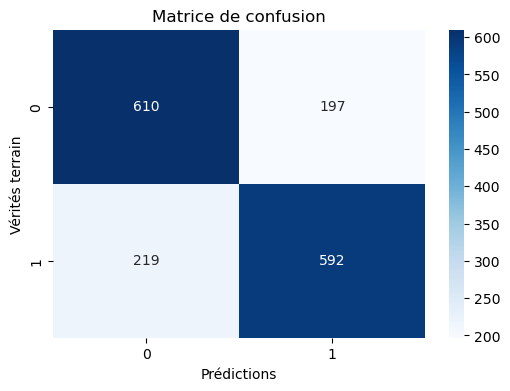

Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       807
           1       0.75      0.73      0.74       811

    accuracy                           0.74      1618
   macro avg       0.74      0.74      0.74      1618
weighted avg       0.74      0.74      0.74      1618



In [216]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des pr√©dictions sur le jeu de test
y_pred_probs = model_use.predict(X_test_embedded)  # Pr√©dictions en probabilit√©s
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Pr√©dictions')
plt.ylabel('V√©rit√©s terrain')
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


# Test Roberta tweets sentiment analysis pr√©-entrain√© vs fine-tuning

## Mod√®le Roberta Tweets pr√©-entrain√©

In [ ]:
# pip install transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report

# Charger le tokenizer et le mod√®le depuis Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# V√©rifier si un GPU est disponible et d√©finir l'appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fonction pour pr√©dire le sentiment avec le mod√®le pr√©-entrain√©
def predict_sentiment_roberta(texts):
    # Tokeniser les textes en entr√©e
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    # Passer le mod√®le en mode d'√©valuation
    model.eval()

    # Passer en avant, obtenir les logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Obtenir les classes pr√©dites
    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1)

    return predicted_classes

# Mapper les pr√©dictions du mod√®le RoBERTa √† vos √©tiquettes cibles
def map_roberta_to_custom_labels(roberta_prediction):
    # RoBERTa a 3 classes : [n√©gatif, neutre, positif]
    # Nous allons mapper neutre et n√©gatif √† 'n√©gatif' (1), positif √† 'positif' (0)
    return 1 if roberta_prediction in [0, 1] else 0

# Processus pour pr√©dire les sentiments sur les donn√©es
def process_and_predict(df):
    predicted_labels = []

    for text in df['text']:
        # Pr√©dire le sentiment pour chaque tweet
        roberta_prediction = predict_sentiment_roberta([text])[0].item()

        # Mapper le sentiment RoBERTa √† vos labels customis√©s
        custom_label = map_roberta_to_custom_labels(roberta_prediction)
        predicted_labels.append(custom_label)

    return predicted_labels

# Augmentation des hyperparam√®tres : Augmenter le nombre d'√©poques
num_epochs = 5  # Essaye de jouer avec ce param√®tre pour observer les r√©sultats

# Tuning de l'hyperparam√®tre : Taille maximale des tokens
max_length = 256  # Ajuster selon tes besoins (par exemple, 128, 256, 512)

# Pr√©diction sur le jeu de donn√©es d'entra√Ænement et de test
train_predictions = process_and_predict(train_df)
train_labels = train_df['target'].tolist()

test_predictions = process_and_predict(test_df)
test_labels = test_df['target'].tolist()

# √âvaluer les r√©sultats
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Rapport de classification pour plus d'informations
print("\nClassification Report on Train Data:")
print(classification_report(train_labels, train_predictions, target_names=["positive", "negative"]))

print("\nClassification Report on Test Data:")
print(classification_report(test_labels, test_predictions, target_names=["positive", "negative"]))


La tendance du mod√®le pr√©-entrain√© est de bien mieux pr√©dire la classe 0 (sentiment positif) et le r√©sultat en terme d'exactitude de pr√©diction est √©quivalent √† celui obtenu par simple r√©gression logistique.

## Mod√®le Roberta Tweets fine-tun√©

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Freeze all layers except the last classification layer
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class to handle tokenization
class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        target = self.targets[index]

        # Tokenization
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# # Sous-√©chantillonage de train_df
# from sklearn.model_selection import train_test_split

# # Taille de l'√©chantillon (20% du total)
# sample_size = 0.2

# # Cr√©ation du sous-√©chantillon avec stratification sur la colonne 'target'
# train_sample, _ = train_test_split(train_df,
#                                    test_size=1 - sample_size,
#                                    stratify=train_df['target'],
#                                    random_state=42)

# # Affichage de la r√©partition des classes dans le sous-√©chantillon
# print(train_sample['target'].value_counts(normalize=True))

In [ ]:
# Recap mod√®le et assignation de device pour le calcul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from tweet_dataset import TweetDataset  # Importer la classe depuis le module s√©par√©

# Function to create the DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(
        texts=df['text'].to_numpy(),
        targets=df['target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4  # Adjust according to your machine
    )

In [ ]:
# Main execution block
if __name__ == "__main__":
    maxlen = 40  # Max tokens
    batch_size = 16  # Increase to lower calculation time

    # Prepare the data
    train_dataloader = create_data_loader(train_df, tokenizer, maxlen, batch_size)
    test_dataloader = create_data_loader(test_df, tokenizer, maxlen, batch_size)
    # Example usage of DataLoader (test de l'utilisation de la classe tweet_dataset
    # for batch in train_dataloader:
    #     print(batch)
    #     break  # Remove this line to process the full dataset

In [ ]:
from torch.optim import AdamW
# Optimizer and learning rate (adjustable)
optimizer = AdamW(model.parameters(), lr=0.0001)

In [ ]:
# Training function
def train_epoch(model, dataloader, optimizer, device):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        total_correct += torch.sum(preds == targets)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()

    return total_correct.double() / total_samples, total_loss / total_samples

# Evaluation function
def eval_model(model, dataloader, device):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == targets)
            total_samples += targets.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = total_correct.double() / total_samples
    return accuracy, predictions, true_labels

In [ ]:
epochs = 20  # Adjust as necessary

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

In [ ]:
# Evaluate the model on the test set
test_acc, test_preds, test_true = eval_model(model, test_dataloader, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Classification report
print("\nClassification Report on Test Data:")
print(classification_report(test_true, test_preds, target_names=["positive", "negative"]))

In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%H_%M")

# Save the model
model_save_path = f'./models/roberta_fine_tuned_{dt_string}'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")

Le fine-tuning permet de gagner 10% d'exactitude, la classe positive a un meilleur recall que la classe n√©gative ce qui est int√©ressant pour notre application m√©tier.

# Test de d√©ploiement local du meilleur mod√®le avanc√©

### Streamlit (retourne positif ou n√©gatif)

In [83]:
# Ajustement de l'environnement aux d√©pendances du mod√®le
import mlflow

# Remplacez `model_uri` par le chemin de votre mod√®le
model_uri = 'runs:/9da4f92db62c447eb958dfd7f07133ce/bert_with_preprocessing'
env_file = mlflow.pyfunc.get_model_dependencies(model_uri)

# Installez les d√©pendances
import subprocess
subprocess.call(["pip", "install", "-r", env_file])


2024/11/13 16:50:01 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r C:\Users\cecil\AppData\Local\Temp\tmprzzf0db9\bert_with_preprocessing\requirements.txt'.


0

In [ ]:
%pip install -r C:\Users\cecil\AppData\Local\Temp\tmprzzf0db9\bert_with_preprocessing\requirements.txt

In [85]:
# Suppression des op√©rations personnalis√©es oneDNN
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [88]:
# Dans le terminal: streamlit run app.py
import subprocess

# Remplacez `app.py` par le nom de votre fichier Streamlit
process = subprocess.Popen(["streamlit", "run", "app.py"])

# Vous pouvez ajouter un lien vers l'application dans le notebook
from IPython.display import display, Markdown
display(Markdown("[Cliquez ici pour ouvrir l'application Streamlit](http://localhost:8501)"))


[Cliquez ici pour ouvrir l'application Streamlit](http://localhost:8501)

### Flask

In [185]:
# %run deploiement_local_flask.py
%run deploiement_local_flask_modeleAzure.py

 * Serving Flask app 'deploiement_local_flask_modeleAzure'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Nov/2024 10:55:46] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Nov/2024 10:55:46] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [21/Nov/2024 10:55:59] "POST / HTTP/1.1" 200 -


Le mod√®le est fonctionnel avec le serving local en le chargeant depuis le registry local ou depuis le stockage Azure.<br>
Par contre la solution gratuite d'Azure Webapp ne permet pas de d√©ployer ce mod√®le;